In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
# from utils.evaluation import find_landfalling_tcs,tc_region

In [2]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [3]:
# open storm dataset

# define filenames and paths
tc_dir = '/user/home/al18709/work/event_sets/wgan_scalar/'
tc_dir2 = '/user/home/al18709/work/event_sets/wgan_modular/'
tc_dir3 = '/user/home/al18709/work/event_sets/wgan_scalar/'
tc_dir4 = '/user/home/al18709/work/event_sets/wgan/'
tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
# storm = '2017260N12310' # Maria
# dataset = 'validation' # Maria
storm = '2019314N14136' # Kalmaegi
dataset = 'test' # Kalmaegi
storm = '2019216N16147' # Krosa
dataset = 'validation' # Krosa
storm = '2006237N13298' # Krosa
dataset = 'validation' # Krosa
# 2006237N13298
storm_filename = f'{dataset}_mraw_{storm}.nc'
storm_filename2 = f'{dataset}_1and2_{storm}.nc'
storm_filename3 = f'{dataset}_{storm}.nc'

# load storm scores
storm_scores = np.load(tc_dir2 + f'{dataset}_mraw_critic_{storm}.npy')
storm_scores2 = np.load(tc_dir2 + f'{dataset}_1and2_critic_{storm}.npy')


# load rain data
storm = xr.open_dataset(tc_dir2 + storm_filename)
storm2 = xr.open_dataset(tc_dir2 + storm_filename2)
storm_truth = xr.open_dataset(tc_dir_truth + 'validation_2006237N13298.nc')
storm3 = xr.open_dataset(tc_dir3 + storm_filename3)
storm4 = xr.open_dataset(tc_dir4 + storm_filename3)
# storm4 = storm3

In [4]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50, 75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100
ntime,_,_,_ = storm.precipitation.shape

rain = storm.precipitation[0,:,:,0]
rain2 = storm2.precipitation[0,:,:,0]
rain3 = storm3.precipitation[0,:,:,0]
rain4 = storm4.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


In [5]:
# find storm extent
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(326, 252)
(326, 252)


In [6]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain2 = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain3 = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain4 = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	for i in range(20):
		storm_rain = storm.precipitation[t,:,:,i]
		grid_rain[t,sel[1],sel[0],i] = storm_rain
		storm_rain2 = storm2.precipitation[t,:,:,i]
		grid_rain2[t,sel[1],sel[0],i] = storm_rain2
		storm_rain3 = storm3.precipitation[t,:,:,i]
		grid_rain3[t,sel[1],sel[0],i] = storm_rain3
		storm_rain4 = storm4.precipitation[t,:,:,i]
		grid_rain4[t,sel[1],sel[0],i] = storm_rain4

	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [7]:
total_storm_rain = np.sum(grid_rain[:,:,:,0],axis=0)
total_storm_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)
total_storm_rain3 = np.sum(grid_rain3[:,:,:,0],axis=0)
total_storm_rain4 = np.sum(grid_rain4[:,:,:,0],axis=0)
total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
rain_bool2 = total_storm_rain2 > 50
rain_bool3 = total_storm_rain3 > 50
rain_bool4 = total_storm_rain4 > 50
print(np.sum(rain_bool))
rain_grid_x2 = grid_x[rain_bool2]
rain_grid_x3 = grid_x[rain_bool3]
rain_grid_x4 = grid_x[rain_bool4]

rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

4926
5084


In [8]:
hit = (rain_bool == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss = (rain_bool == False) & (rain_bool_truth == True)
hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
print('Hit rate: ',hit_rate*100)

false_alarm = (rain_bool == True) & (rain_bool_truth == False)
correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
print('false alarm rate',false_alarm_rate*100)

hit2 = (rain_bool2 == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss2 = (rain_bool2 == False) & (rain_bool_truth == True)
hit_rate2 = np.sum(hit2) / (np.sum(hit2) + np.sum(miss2))
print('Hit rate2: ',hit_rate2*100)

false_alarm2 = (rain_bool2 == True) & (rain_bool_truth == False)
correct_rejection2 = (rain_bool2 == False) & (rain_bool_truth == False)
false_alarm_rate2 = np.sum(false_alarm2)/(np.sum(false_alarm2) + np.sum(correct_rejection2))
print('false alarm rate2',false_alarm_rate2*100)

hit3 = (rain_bool3 == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss3 = (rain_bool3 == False) & (rain_bool_truth == True)
hit_rate3 = np.sum(hit2) / (np.sum(hit3) + np.sum(miss3))
print('Hit rate3: ',hit_rate3*100)

false_alarm3 = (rain_bool3 == True) & (rain_bool_truth == False)
correct_rejection3 = (rain_bool3 == False) & (rain_bool_truth == False)
false_alarm_rate3 = np.sum(false_alarm3)/(np.sum(false_alarm3) + np.sum(correct_rejection3))
print('false alarm rate3',false_alarm_rate3*100)

hit4 = (rain_bool4 == True) & (rain_bool_truth == True)
print(np.sum(hit))
miss4 = (rain_bool4 == False) & (rain_bool_truth == True)
hit_rate4 = np.sum(hit4) / (np.sum(hit4) + np.sum(miss4))
print('Hit rate4: ',hit_rate4*100)

false_alarm4 = (rain_bool4 == True) & (rain_bool_truth == False)
correct_rejection4 = (rain_bool4 == False) & (rain_bool_truth == False)
false_alarm_rate4 = np.sum(false_alarm4)/(np.sum(false_alarm4) + np.sum(correct_rejection4))
print('false alarm rate4',false_alarm_rate4*100)

# equitable threat score is:
# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# http://cimss.ssec.wisc.edu/goes/comet/threat.html
# ETS = (hits - E) / (hits + misses + false alarms - E)
# E = (number of forecast points * number of observed points) / total number of points possible

n_forecast_points = np.sum(rain_bool == True)
n_observed_points = np.sum(rain_bool_truth == True)
total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points*n_observed_points) / total_points_possible
ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
print('ETS: ', ETS)


n_forecast_points2 = np.sum(rain_bool2 == True)
n_observed_points2 = np.sum(rain_bool_truth == True)
total_points_possible2 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points2*n_observed_points2) / total_points_possible2
ETS = (np.sum(hit2) - E) / (np.sum(hit2) + np.sum(miss2) + np.sum(false_alarm2) - E)
print('ETS2: ', ETS)

n_forecast_points3 = np.sum(rain_bool3 == True)
n_observed_points3 = np.sum(rain_bool_truth == True)
total_points_possible3 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points3*n_observed_points3) / total_points_possible3
ETS = (np.sum(hit3) - E) / (np.sum(hit3) + np.sum(miss3) + np.sum(false_alarm3) - E)
print('ETS3: ', ETS)

n_forecast_points4 = np.sum(rain_bool4 == True)
n_observed_points4 = np.sum(rain_bool_truth == True)
total_points_possible4 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
E = (n_forecast_points4*n_observed_points4) / total_points_possible4
ETS = (np.sum(hit4) - E) / (np.sum(hit4) + np.sum(miss4) + np.sum(false_alarm4) - E)
print('ETS4: ', ETS)
# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

4263
Hit rate:  83.85129819040125
false alarm rate 0.8602792339232884
4263
Hit rate2:  75.74744295830055
false alarm rate2 9.002439404162557
4263
Hit rate3:  75.74744295830055
false alarm rate3 3.7149011262780918
4263
Hit rate4:  81.96302124311565
false alarm rate4 0.87844500960191
ETS:  0.7273138080434861
ETS2:  0.28036198989620775
ETS3:  0.271670009863906
ETS4:  0.7081242360316345


In [9]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [10]:
accumulated_rain = np.sum(grid_rain,axis=0)
accumulated_rain2 = np.sum(grid_rain2,axis=0)
accumulated_rain3 = np.sum(grid_rain3,axis=0)
accumulated_rain4 = np.sum(grid_rain4,axis=0)

In [11]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
population = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_264531/1317023007.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144
/tmp/ipykernel_264531/1317023007.py:5: RuntimeWarning: overflow encountered in multiply
  population = population_count.population.values * 144


In [12]:
print(data.shape)

(1800, 3600)


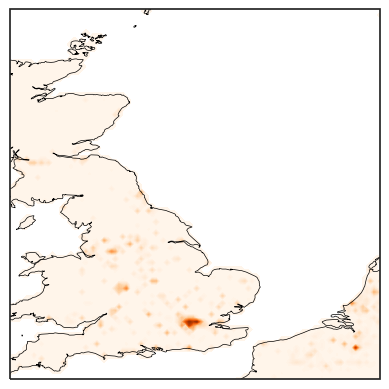

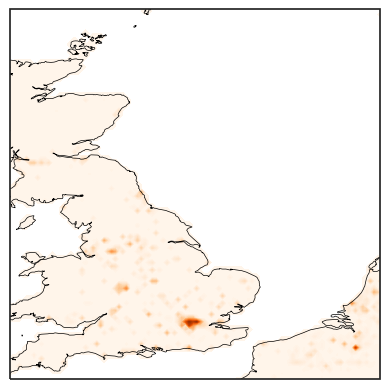

7985169400.0
7985169400.0


In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
levels = range(1,1500000,20000)
data[data == -inf] = 0
# levels = [1,1000,5000,10000,100000,120000,160000,180000,200000,400000,600000,800000,1000000,2000000,3000000,4000000,5000000]
ax.contourf(lon,-lat + 12,data,levels=levels, transform=ccrs.PlateCarree(),cmap='Oranges')
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.set_extent([-5, 5, 50, 60], crs=ccrs.PlateCarree())	
plt.show()

pop_new = data[::-1, :]

blank_rows = np.zeros((120, pop_new.shape[1]))  # Create an array of zeros with the same number of columns as arr
pop_new_new = np.insert(pop_new, 0, blank_rows, axis=0)
pop_new_new_new = pop_new_new[:-120,:]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
levels = range(1,1500000,20000)
ax.contourf(lon,lat,pop_new_new_new,levels=levels, transform=ccrs.PlateCarree(),cmap='Oranges')
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.set_extent([-5, 5, 50, 60], crs=ccrs.PlateCarree())	
plt.show()

print(np.sum(data))
print(np.sum(pop_new))

In [14]:
# plt.imshow(data)
print(np.min(data))
data[data == -inf] = 0

0.0


In [15]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=0
# vmax=300


# fig, ax = plt.subplots(figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

# ax.contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
# ax.contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
# # ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)


# ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
# ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# # plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# # ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}
# # ax.set_xticklabels(labelsize=20)
# # ax.set_yticklabels(labelsize=20)
# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y', labelsize=20)

# precip_cmap,precip_norm = make_cmap(high_vals=True)
# # cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# # cbar.ax.tick_params(labelsize=8,width=0.5)
# # cbar.ax.tick_params(labelsize=20)

# ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
# # ax.set_title('title',fontsize=26,pad=15)

# plt.savefig('figure_7a_irma_rain.png',bbox_inches='tight')

In [16]:
print(grid_x)
print(grid_y)

[[-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 ...
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]
 [-85.95     -85.85     -85.74999  ... -61.05     -60.95     -60.850002]]
[[ 8.749995  8.749995  8.749995 ...  8.749995  8.749995  8.749995]
 [ 8.850001  8.850001  8.850001 ...  8.850001  8.850001  8.850001]
 [ 8.95      8.95      8.95     ...  8.95      8.95      8.95    ]
 ...
 [41.05     41.05     41.05     ... 41.05     41.05     41.05    ]
 [41.15     41.15     41.15     ... 41.15     41.15     41.15    ]
 [41.25     41.25     41.25     ... 41.25     41.25     41.25    ]]


In [17]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain[:,:,:,0],axis=0)
accumulated_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)
accumulated_rain3 = np.sum(grid_rain3[:,:,:,0],axis=0)
accumulated_rain4 = np.sum(grid_rain4[:,:,:,0],axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain2 = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain3 = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain4 = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain2 = accumulated_rain2
storm_rain3 = accumulated_rain3
storm_rain4 = accumulated_rain4
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

global_rain[sel[1],sel[0]] = storm_rain
global_rain2[sel[1],sel[0]] = storm_rain2
global_rain3[sel[1],sel[0]] = storm_rain3
global_rain4[sel[1],sel[0]] = storm_rain4
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
max rain 252.54801664183464
max rain 334.8124869460173


In [18]:
print(pred_exposure)
print(truth_exposure)

2782.253
9932.632


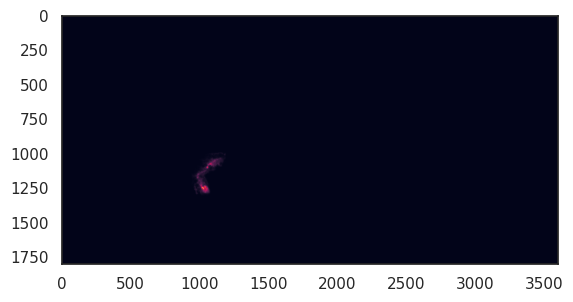

In [19]:
plt.imshow(global_rain)

In [20]:
def crop_blob(array_to_crop,boolean_array):
    # Find indices of True values along rows and columns
    true_rows, true_cols = np.where(boolean_array)

    # Determine boundaries of the blob
    top = true_rows.min()
    bottom = true_rows.max()
    left = true_cols.min()
    right = true_cols.max()

    # Crop the array
    # print(array_to_crop.shape)
    # print(top,bottom,left,right)
    cropped_array = array_to_crop[top:bottom+1, left:right+1]

    return cropped_array

In [21]:
def ets(total_storm_rain,total_storm_rain_truth,pop,threshold=50):

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	print('Hit rate: ',hit_rate*100)

	# population
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)
	# pop_hit_rate = pop_hit
	datapop = np.copy(pop)
	datapop[~hit] = 0
	print('pop hits',np.sum(datapop))
	# fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
	# c = ax.contourf(lon,lat,datapop,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
	# ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
	# plt.colorbar(c)
	# plt.show()


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	# correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	rain_bool_truth_crop = crop_blob(rain_bool_truth,rain_bool_truth)
	rain_bool_crop = crop_blob(rain_bool,rain_bool_truth)
	correct_rejection = (rain_bool_crop == False) & (rain_bool_truth_crop == False)
	print('correct rejection = ',correct_rejection)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	print('false alarm rate',false_alarm_rate*100)
	# print(pop.shape)
	# print(false_alarm.shape)
	# print(pop[false_alarm].shape)
	# data2 = np.copy(pop)
	# data2[~false_alarm] = 0
	# print(np.sum(data2))
	# print(data2.shape)
	# fig, ax = plt.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})
	# c = ax.contourf(lon,lat,data2,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
	# ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
	# plt.colorbar(c)
	# plt.show()
	# print(pop[false_alarm])
	pop_false_alarm = np.sum(pop[false_alarm])
	print('pop_false alarm', pop_false_alarm)
	# pop_correct_rejection = np.sum(pop[correct_rejection])
	crop_pop = crop_blob(pop,rain_bool_truth)
	pop_correct_rejection = np.sum(crop_pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)
	# pop_false_alarm_rate = pop_false_alarm

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	print(ETS_pop)

	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [22]:
print(pop)

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0
pop_new = global_pop[::-1, :]

blank_rows = np.zeros((120, pop_new.shape[1]))  # Create an array of zeros with the same number of columns as arr
pop_new_new = np.insert(pop_new, 0, blank_rows, axis=0)
global_pop_new = pop_new_new[:-120,:]
# plt.contourf(lon,-lat + 12,data,levels=levels, transform=ccrs.PlateCarree(),cmap='Oranges')


<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


In [23]:
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain,global_rain_truth,global_pop_new,threshold=100)

hit_rate2,false_alarm_rate2,ETS2,pop_hit2,pop_miss2,pop_hit_rate2,pop_false_alarm2,pop_correct_rejection2,pop_false_alarm_rate2 = ets(global_rain2,global_rain_truth,global_pop_new,threshold=100)

hit_rate3,false_alarm_rate3,ETS3,pop_hit3,pop_miss3,pop_hit_rate3,pop_false_alarm3,pop_correct_rejection3,pop_false_alarm_rate3 = ets(global_rain3,global_rain_truth,global_pop_new,threshold=100)

hit_rate4,false_alarm_rate4,ETS4,pop_hit4,pop_miss4,pop_hit_rate4,pop_false_alarm4,pop_correct_rejection4,pop_false_alarm_rate4 = ets(global_rain4,global_rain_truth,global_pop_new,threshold=100)

Hit rate:  69.86506746626686
pop hits 2059217.0
correct rejection =  [[ True  True  True ... False False False]
 [ True  True  True ... False  True False]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
false alarm rate 1.1855500821018061
pop_false alarm 1003390.56
ETS:  0.5497818052136006
0.41205603


Hit rate:  28.335832083958024
pop hits 896828.94
correct rejection =  [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
false alarm rate 5.184565378302707
pop_false alarm 2202108.5
ETS:  0.12823193292259605
0.14457707
Hit rate:  10.044977511244378
pop hits 59453.977
correct rejection =  [[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
false alarm rate 3.4137134303101306
pop_false alarm 5106154.5
ETS:  0.05613517988545091
0.00625278
Hit rate:  79.01049475262369
pop hits 2986305.8
correct rejection =  [[ True  True  True ... False False False]
 [ True  True  True ...

In [24]:
print(pop_hit_rate * 100)
print(pop_false_alarm_rate * 100)
print(grid_rain.shape)
print(grid_rain_truth.shape)


51.585596799850464
1.3972751796245575
(45, 326, 252, 20)
(45, 326, 252)


In [25]:
n_time_steps,n,m,_ = grid_rain.shape
combo_rain = np.zeros((n_time_steps,n,m))
print(storm_scores.shape)
for t in range(n_time_steps):
	t_scores = storm_scores[t,:]
	best_score = np.argmax(t_scores)
	combo_rain[t,:,:] = grid_rain[t,:,:,best_score]

ensemble_combo = np.sum(combo_rain,axis=0)
print(t_scores)
print(ensemble_combo.shape)

(45, 1, 20)
[[45.87889099 46.05871201 44.90998459 45.52531815 43.32776642 45.44566727
  45.67199707 44.73448563 44.49699402 45.61149979 44.32965088 43.98858643
  43.95320129 45.2195549  45.15673447 45.92517853 44.98853302 45.9836731
  46.20258713 45.10911942]]
(326, 252)


[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


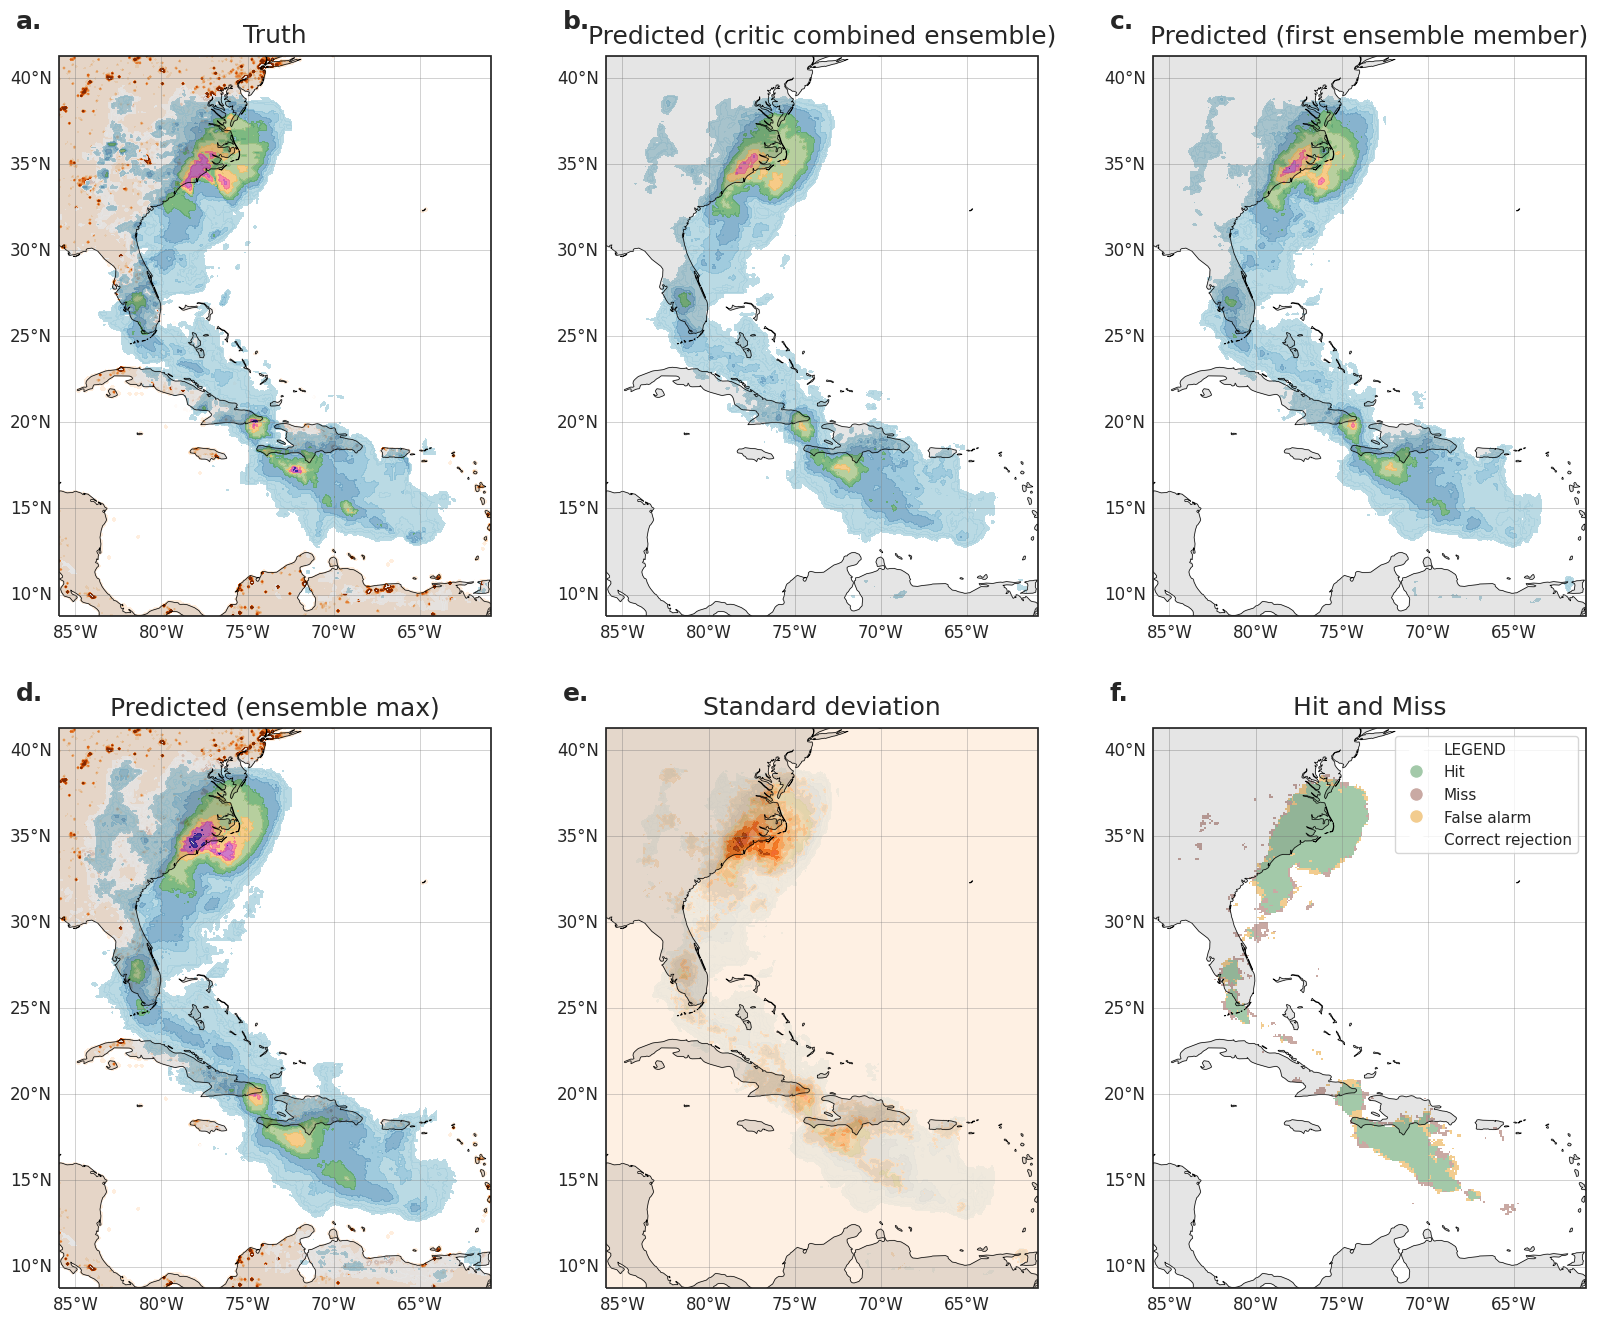

In [26]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, axes = plt.subplots(2,3,figsize=(20,16),subplot_kw={'projection': ccrs.PlateCarree()})
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
axes[0,0].contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
m = axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel
axes[1,0].contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')

agreement_range = 20
ensemble_max = np.max(np.sum(grid_rain[:,:,:,:],axis=0),axis=-1)
agree_mask = np.all([np.abs(np.sum(grid_rain[:,:,:,0],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,1],axis=0) - ensemble_max) <= agreement_range,
                    np.abs(np.sum(grid_rain[:,:,:,2],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,3],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,4],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,5],axis=0) - ensemble_max) <= agreement_range,
					np.abs(np.sum(grid_rain[:,:,:,6],axis=0) - ensemble_max) <= agreement_range],
					axis=0)
print(agree_mask)
agree_mask = np.all([agree_mask,ensemble_max > 10],axis=0)
axes[0,1].contourf(grid_x,grid_y,ensemble_combo,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
axes[0,2].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

axes[1,0].contourf(grid_x,grid_y,ensemble_max,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
axes[1,1].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

stand_dev = np.std(np.sum(grid_rain[:,:,:,:],axis=0),axis=-1)

axes[1,1].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)
# Create a hatching pattern
hatching_pattern = ['/', '\\', '//', '\\\\', '-', '|', '+', 'x', 'o', 'O', '.', '*'][-1]
# Add hatching to the areas of agreement
# axes[1].contourf(grid_x, grid_y, 1* agree_mask,1,hatches=['','////'],colors='none',transform=ccrs.PlateCarree())



h = axes[1,2].pcolormesh(grid_x,grid_y,rain_data,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

for i in range(3):
	for j in range(2):
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=18, weight='bold')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=18, weight='bold')
axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=18, weight='bold')
axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=18, weight='bold')
axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=18, weight='bold')
axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=18, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[1,2].legend(handles=legend_handles, loc='upper right')

axes[0,0].set_title('Truth',fontsize=18,pad=10)
axes[0,1].set_title('Predicted (critic combined ensemble)',fontsize=18,pad=10)
axes[0,2].set_title('Predicted (first ensemble member)',fontsize=18,pad=10)
axes[1,0].set_title('Predicted (ensemble max)',fontsize=18,pad=10)
axes[1,1].set_title('Standard deviation',fontsize=18,pad=10)
axes[1,2].set_title('Hit and Miss',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


plt.savefig('figure_7b_hitmiss.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


In [27]:
# TODO 
# the question is, what level of extreme rainfall can we be confident in calculating the exposure to?
# how often are we wrong when it's 50mm,100mm,150mm
# how often are we right?
# do the ensemble combining method with critic score so best of 20 images are selected


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


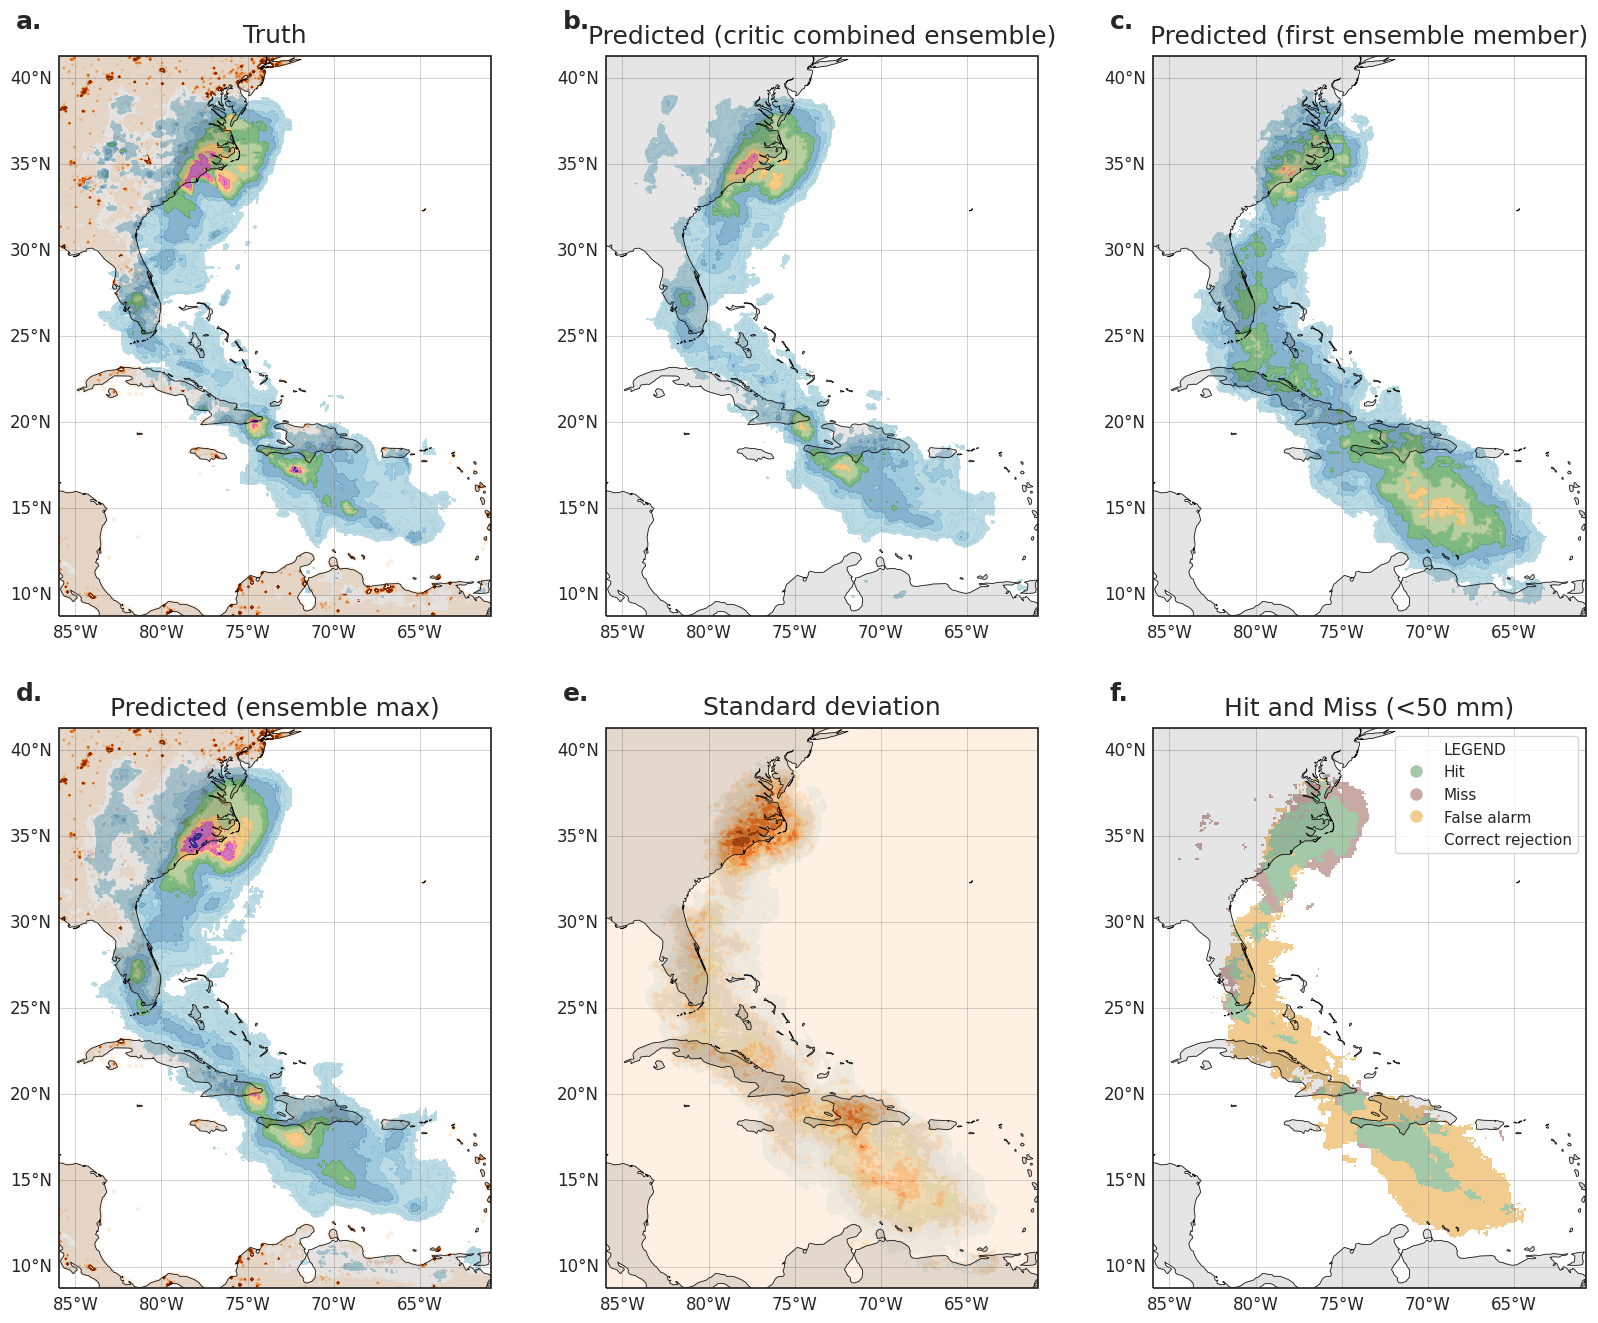

In [28]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, axes = plt.subplots(2,3,figsize=(20,16),subplot_kw={'projection': ccrs.PlateCarree()})

rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
axes[0,0].contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')
m = axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel
axes[1,0].contourf(lon,-lat + 12,data,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')


# agreement_range = 20
# ensemble_max = np.max(np.sum(grid_rain2[:,:,:,:],axis=0),axis=-1)
# agree_mask = np.all([np.abs(np.sum(grid_rain2[:,:,:,0],axis=0) - ensemble_max) <= agreement_range,
#                     np.abs(np.sum(grid_rain2[:,:,:,1],axis=0) - ensemble_max) <= agreement_range,
#                     np.abs(np.sum(grid_rain2[:,:,:,2],axis=0) - ensemble_max) <= agreement_range,
# 					np.abs(np.sum(grid_rain2[:,:,:,3],axis=0) - ensemble_max) <= agreement_range,
# 					np.abs(np.sum(grid_rain2[:,:,:,4],axis=0) - ensemble_max) <= agreement_range,
# 					np.abs(np.sum(grid_rain2[:,:,:,5],axis=0) - ensemble_max) <= agreement_range,
# 					np.abs(np.sum(grid_rain2[:,:,:,6],axis=0) - ensemble_max) <= agreement_range],
# 					axis=0)
# print(agree_mask)
# agree_mask = np.all([agree_mask,ensemble_max > 10],axis=0)
axes[0,1].contourf(grid_x,grid_y,ensemble_combo,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
axes[0,2].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

axes[1,0].contourf(grid_x,grid_y,ensemble_max,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
axes[1,1].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

stand_dev = np.std(np.sum(grid_rain2[:,:,:,:],axis=0),axis=-1)
# 
axes[1,1].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)
# Create a hatching pattern
# hatching_pattern = ['/', '\\', '//', '\\\\', '-', '|', '+', 'x', 'o', 'O', '.', '*'][-1]
# Add hatching to the areas of agreement
# axes[1].contourf(grid_x, grid_y, 1* agree_mask,1,hatches=['','////'],colors='none',transform=ccrs.PlateCarree())


# sixth panel hit and miss mwgan part 1 and 2
h = axes[1,2].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

for i in range(3):
	for j in range(2):
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=18, weight='bold')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=18, weight='bold')
axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=18, weight='bold')
axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=18, weight='bold')
axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=18, weight='bold')
axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=18, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[1,2].legend(handles=legend_handles, loc='upper right')

axes[0,0].set_title('Truth',fontsize=18,pad=10)
axes[0,1].set_title('Predicted (critic combined ensemble)',fontsize=18,pad=10)
axes[0,2].set_title('Predicted (first ensemble member)',fontsize=18,pad=10)
axes[1,0].set_title('Predicted (ensemble max)',fontsize=18,pad=10)
axes[1,1].set_title('Standard deviation',fontsize=18,pad=10)
axes[1,2].set_title('Hit and Miss (<50 mm)',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


plt.savefig('figure_7c_hitmiss_2.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


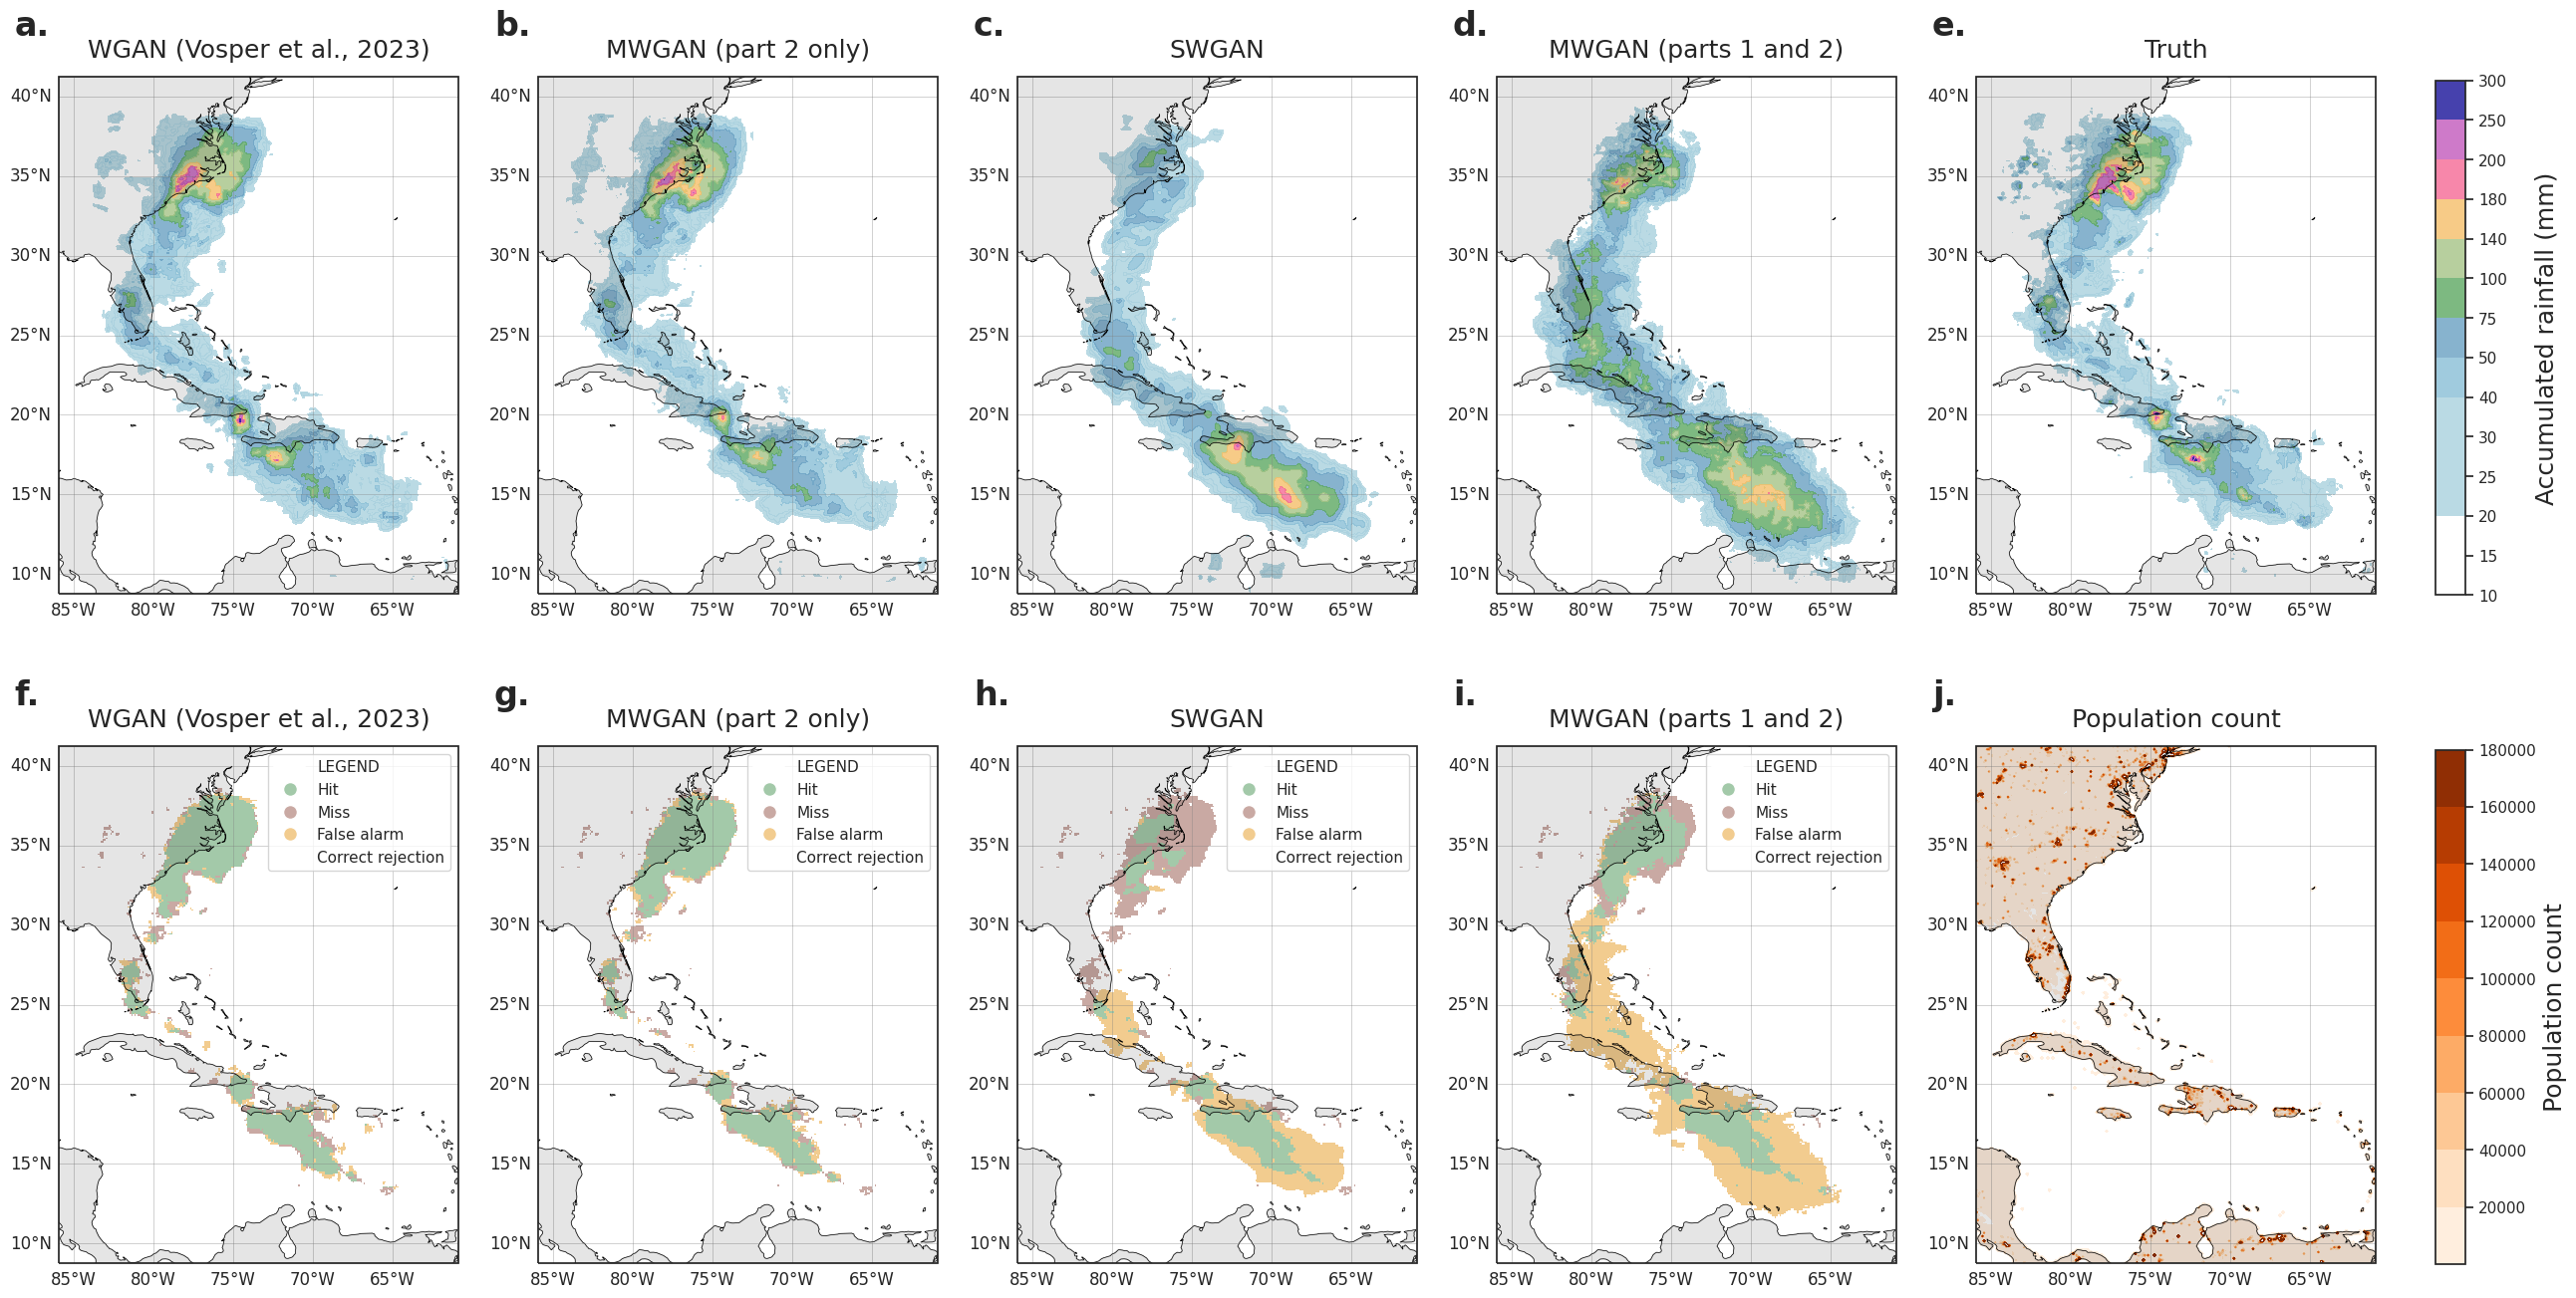

In [29]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2


levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300

fig, axes = plt.subplots(2,5,figsize=(30,16),subplot_kw={'projection': ccrs.PlateCarree()})

# parts 1 and 2
rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection
rain_data_mwgan_parts12 = rain_data_mwgan_parts12.astype(int)

# parts 2
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_part2 = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# swgan
rain1 = np.sum(grid_rain3[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_swgan = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# og wgan
rain1 = np.sum(grid_rain4[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_oggan = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# fifth panel
m = axes[0,4].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel - wgan prediction
axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain4[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# third panel - mwgan part 2 prediction
axes[0,1].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fourth panel - mswgan prediction
axes[0,2].contourf(grid_x,grid_y,np.sum(grid_rain3[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fifth panel - mwgan parts 1 and 2 prediction
axes[0,3].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# sixth panel - table of data
p = axes[1,4].contourf(lon,lat,global_pop_new,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')

# axes[1,0].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)



# seventh panel - hit and miss wgan
h = axes[1,0].pcolormesh(grid_x,grid_y,rain_data_oggan,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# eigth panel - hit and miss mwgan part 2
h = axes[1,1].pcolormesh(grid_x,grid_y,rain_data_mwgan_part2,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# ninth panel - hit and miss swgan
h = axes[1,2].pcolormesh(grid_x,grid_y,rain_data_swgan,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# tenth panel - hit and miss mwgan parts 1 and 2
h = axes[1,3].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

for i in range(5):
	for j in range(2):
		# if (i == 0) and (j == 1):
		# 	continue
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

tsize = 24
left = -0.11
up = 1.08
# axis labels and legends
axes[0,0].text(left,up, 'a.', transform=axes[0,0].transAxes, size=tsize, weight='bold')
axes[0,1].text(left,up, 'b.', transform=axes[0,1].transAxes, size=tsize, weight='bold')
axes[0,2].text(left,up, 'c.', transform=axes[0,2].transAxes, size=tsize, weight='bold')
axes[0,3].text(left,up, 'd.', transform=axes[0,3].transAxes, size=tsize, weight='bold')
axes[0,4].text(left,up, 'e.', transform=axes[0,4].transAxes, size=tsize, weight='bold')
axes[1,0].text(left,up, 'f.', transform=axes[1,0].transAxes, size=tsize, weight='bold')
# axes[0,1].text(0.6, 0.9, f'Hit rate: {}', transform=axes[0,1].transAxes, size=14)
axes[1,1].text(left,up, 'g.', transform=axes[1,1].transAxes, size=tsize, weight='bold')
axes[1,2].text(left,up, 'h.', transform=axes[1,2].transAxes, size=tsize, weight='bold')
axes[1,3].text(left,up, 'i.', transform=axes[1,3].transAxes, size=tsize, weight='bold')
axes[1,4].text(left,up, 'j.', transform=axes[1,4].transAxes, size=tsize, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[1,0].legend(handles=legend_handles, loc='upper right')
axes[1,1].legend(handles=legend_handles, loc='upper right')
axes[1,2].legend(handles=legend_handles, loc='upper right')
axes[1,3].legend(handles=legend_handles, loc='upper right')

padding = 14
axes[0,0].set_title('WGAN (Vosper et al., 2023)',fontsize=18,pad=padding)
axes[0,1].set_title('MWGAN (part 2 only)',fontsize=18,pad=padding)
axes[0,2].set_title('SWGAN',fontsize=18,pad=padding)
axes[0,3].set_title('MWGAN (parts 1 and 2)',fontsize=18,pad=padding)
axes[0,4].set_title('Truth',fontsize=18,pad=padding)
axes[1,0].set_title('WGAN (Vosper et al., 2023)',fontsize=18,pad=padding)
axes[1,1].set_title('MWGAN (part 2 only)',fontsize=18,pad=padding)
axes[1,2].set_title('SWGAN',fontsize=18,pad=padding)
axes[1,3].set_title('MWGAN (parts 1 and 2)',fontsize=18,pad=padding)
axes[1,4].set_title('Population count',fontsize=18,pad=padding)

# add colourbar
cbar_ax = fig.add_axes([0.92, 0.542, 0.01, 0.323])
cb = fig.colorbar(m, cax=cbar_ax,shrink=0.005,ticks=levels).set_label(label='Accumulated rainfall (mm)',size=18, labelpad=20)
cbar_ax = fig.add_axes([0.92, 0.122, 0.01, 0.323])
cb = fig.colorbar(p, cax=cbar_ax,shrink=0.005,ticks=range(0,200000,20000)).set_label(label = 'Population count',size=18,labelpad=5)
# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0,2])

plt.savefig('figure_7c_hitmiss_4_.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


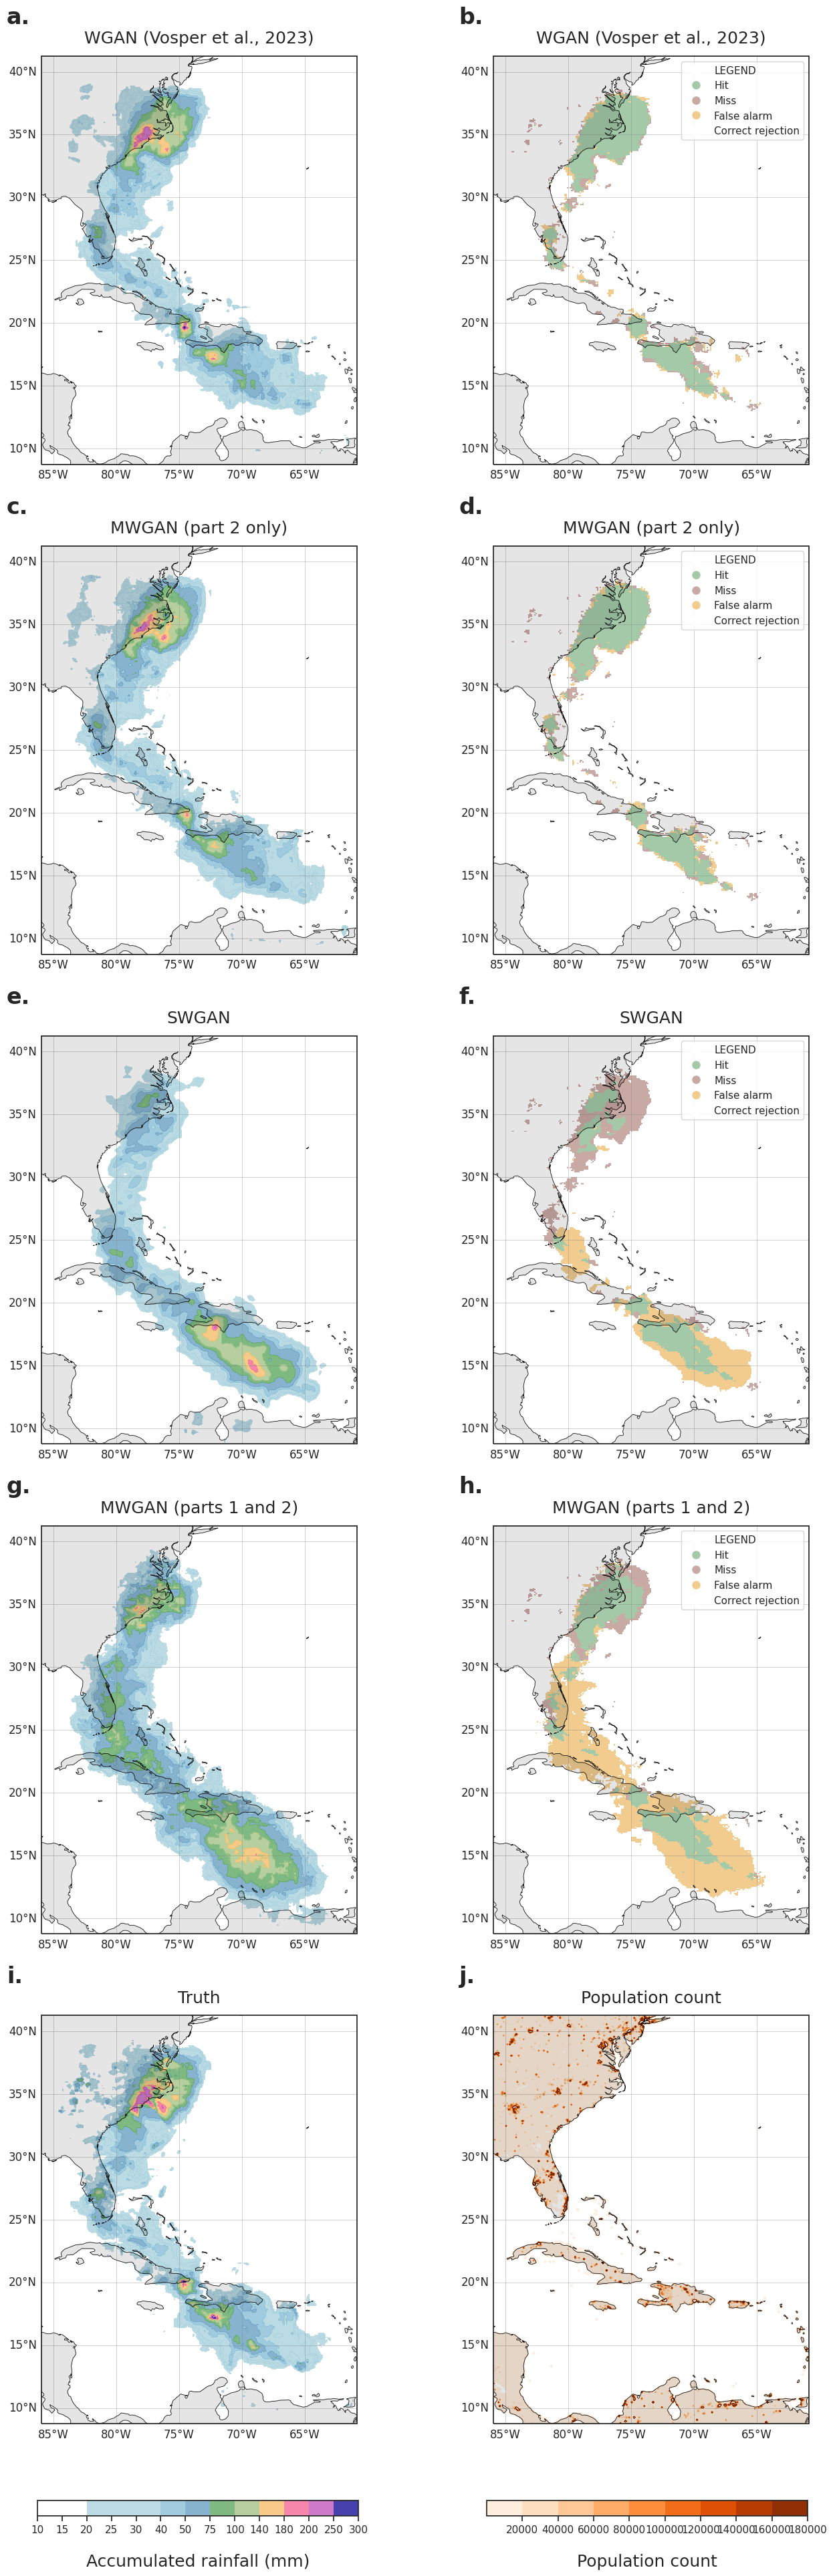

In [30]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2


levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300

fig, axes = plt.subplots(5,2,figsize=(16,46),subplot_kw={'projection': ccrs.PlateCarree()})

# parts 1 and 2
rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection
rain_data_mwgan_parts12 = rain_data_mwgan_parts12.astype(int)

# parts 2
rain1 = np.sum(grid_rain[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_part2 = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# swgan
rain1 = np.sum(grid_rain3[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_swgan = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# og wgan
rain1 = np.sum(grid_rain4[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_oggan = hit + 2* miss + 3* false_alarm + 4*correct_rejection


# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')

# fifth panel
m = axes[4,0].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel - wgan prediction
axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain4[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# third panel - mwgan part 2 prediction
axes[1,0].contourf(grid_x,grid_y,np.sum(grid_rain[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fourth panel - mswgan prediction
axes[2,0].contourf(grid_x,grid_y,np.sum(grid_rain3[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fifth panel - mwgan parts 1 and 2 prediction
axes[3,0].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# sixth panel - table of data
p = axes[4,1].contourf(lon,lat,global_pop_new,levels=range(1,200000,20000), transform=ccrs.PlateCarree(),cmap='Oranges')

# axes[1,0].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)



# seventh panel - hit and miss wgan
h = axes[0,1].pcolormesh(grid_x,grid_y,rain_data_oggan,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# eigth panel - hit and miss mwgan part 2
h = axes[1,1].pcolormesh(grid_x,grid_y,rain_data_mwgan_part2,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# ninth panel - hit and miss swgan
h = axes[2,1].pcolormesh(grid_x,grid_y,rain_data_swgan,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# tenth panel - hit and miss mwgan parts 1 and 2
h = axes[3,1].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

for i in range(2):
	for j in range(5):
		# if (i == 0) and (j == 1):
		# 	continue
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

tsize = 24
left = -0.11
up = 1.08
# axis labels and legends
axes[0,0].text(left,up, 'a.', transform=axes[0,0].transAxes, size=tsize, weight='bold')
axes[1,0].text(left,up, 'c.', transform=axes[1,0].transAxes, size=tsize, weight='bold')
axes[2,0].text(left,up, 'e.', transform=axes[2,0].transAxes, size=tsize, weight='bold')
axes[3,0].text(left,up, 'g.', transform=axes[3,0].transAxes, size=tsize, weight='bold')
axes[4,0].text(left,up, 'i.', transform=axes[4,0].transAxes, size=tsize, weight='bold')
axes[0,1].text(left,up, 'b.', transform=axes[0,1].transAxes, size=tsize, weight='bold')
# axes[0,1].text(0.6, 0.9, f'Hit rate: {}', transform=axes[0,1].transAxes, size=14)
axes[1,1].text(left,up, 'd.', transform=axes[1,1].transAxes, size=tsize, weight='bold')
axes[2,1].text(left,up, 'f.', transform=axes[2,1].transAxes, size=tsize, weight='bold')
axes[3,1].text(left,up, 'h.', transform=axes[3,1].transAxes, size=tsize, weight='bold')
axes[4,1].text(left,up, 'j.', transform=axes[4,1].transAxes, size=tsize, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[0,1].legend(handles=legend_handles, loc='upper right')
axes[1,1].legend(handles=legend_handles, loc='upper right')
axes[2,1].legend(handles=legend_handles, loc='upper right')
axes[3,1].legend(handles=legend_handles, loc='upper right')

padding = 14
axes[0,0].set_title('WGAN (Vosper et al., 2023)',fontsize=18,pad=padding)
axes[1,0].set_title('MWGAN (part 2 only)',fontsize=18,pad=padding)
axes[2,0].set_title('SWGAN',fontsize=18,pad=padding)
axes[3,0].set_title('MWGAN (parts 1 and 2)',fontsize=18,pad=padding)
axes[4,0].set_title('Truth',fontsize=18,pad=padding)
axes[0,1].set_title('WGAN (Vosper et al., 2023)',fontsize=18,pad=padding)
axes[1,1].set_title('MWGAN (part 2 only)',fontsize=18,pad=padding)
axes[2,1].set_title('SWGAN',fontsize=18,pad=padding)
axes[3,1].set_title('MWGAN (parts 1 and 2)',fontsize=18,pad=padding)
axes[4,1].set_title('Population count',fontsize=18,pad=padding)

# add colourbar
# cbar_ax = fig.add_axes([0.92, 0.542, 0.01, 0.323])
cbar_ax = fig.add_axes([0.15, 0.08, 0.3, 0.005])
cb = fig.colorbar(m, cax=cbar_ax,shrink=0.005,ticks=levels,orientation='horizontal').set_label(label='Accumulated rainfall (mm)',size=18, labelpad=20)
# cbar_ax = fig.add_axes([0.92, 0.122, 0.01, 0.323])
cbar_ax = fig.add_axes([0.57, 0.08, 0.3, 0.005])
cb = fig.colorbar(p, cax=cbar_ax,shrink=0.005,ticks=range(0,200000,20000),orientation='horizontal').set_label(label = 'Population count',size=18,labelpad=20)
# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0,2])
# tick_labels = cb.get_xticklabels()
# tick_labels = tick_labels / 1000
plt.savefig('figure_7c_hitmiss_5.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


In [31]:
print(rain_data_mwgan_parts12==1)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


[['', 'WGAN', 'MWGAN \n part 2', 'SWGAN', 'MWGAN \n part 1 and 2'], ['Hit rate (%)', '79.01', '69.87', '10.04', '28.34'], ['False alarm rate (%)', '1.20', '1.19', '3.41', '5.18'], ['Hit rate (%) \n population weighted', '74.81', '51.59', '1.49', '22.47'], ['False alarm rate (%) \n population weighted', '1.92', '1.40', '7.11', '3.07'], ['Population \n exposed to > 50 mm \n correctly predicted', '2,990,000', '2,060,000', '60,000', '900,000'], ['Population \n exposed to > 50 mm \n missed', '1,010,000', '1,930,000', '3,930,000', '3,100,000'], ['Population \n falsley exposed \n to > 50 mm', '1,380,000', '1,000,000', '5,110,000', '2,200,000'], ['ETS', '0.62', '0.55', '0.06', '0.13']]


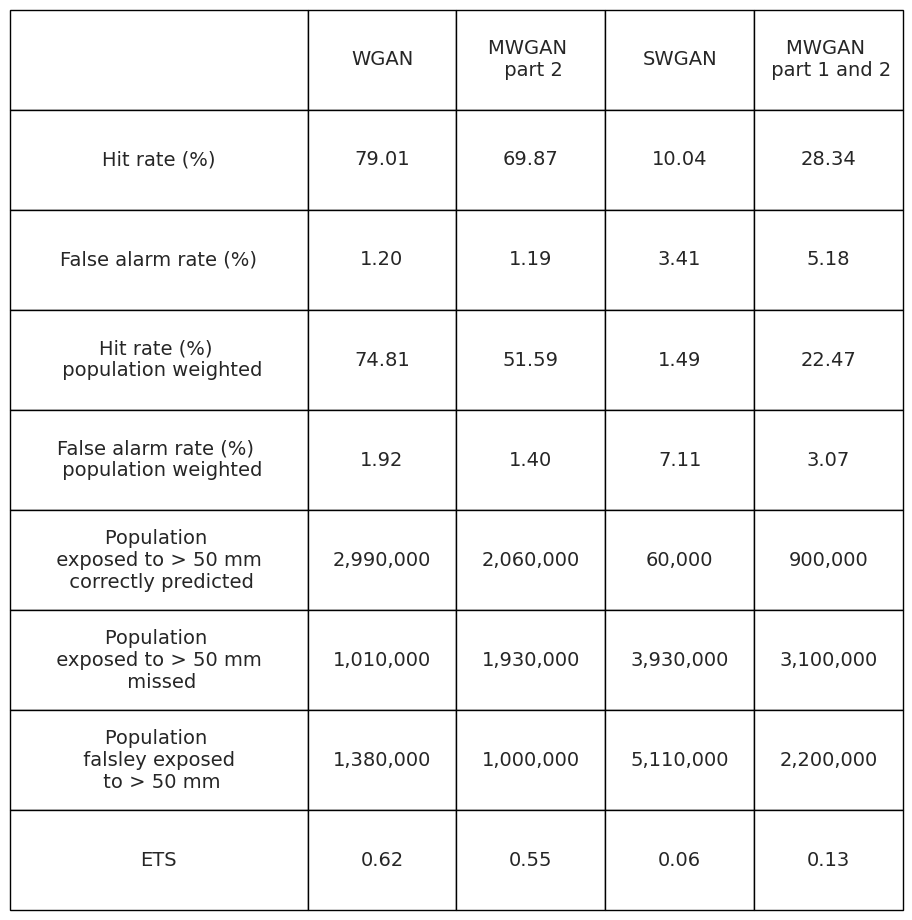

In [32]:
# False alarm rate is so low becuase there are a lot of cells with correct rejection

data = [["", "WGAN", "MWGAN \n part 2","SWGAN", "MWGAN \n part 1 and 2"],
		["Hit rate (%)",f"{hit_rate4*100:.2f}",f"{hit_rate*100:.2f}",f"{hit_rate3*100:.2f}",f"{hit_rate2*100:.2f}"],
		["False alarm rate (%)", f"{false_alarm_rate4*100:.2f}",f"{false_alarm_rate*100:.2f}",f"{false_alarm_rate3*100:.2f}",f"{false_alarm_rate2*100:.2f}"],
        ["Hit rate (%) \n population weighted",f"{pop_hit_rate4*100:.2f}",f"{pop_hit_rate*100:.2f}",f"{pop_hit_rate3*100:.2f}",f"{pop_hit_rate2*100:.2f}"],
		["False alarm rate (%) \n population weighted", f"{pop_false_alarm_rate4*100:.2f}",f"{pop_false_alarm_rate*100:.2f}",f"{pop_false_alarm_rate3*100:.2f}",f"{pop_false_alarm_rate2*100:.2f}"],
		["Population \n exposed to > 50 mm \n correctly predicted", f"{round(pop_hit4,-4):,.0f}",f"{round(pop_hit,-4):,.0f}",f"{round(pop_hit3,-4):,.0f}",f"{round(pop_hit2,-4):,.0f}"],
        ["Population \n exposed to > 50 mm \n missed", f"{round(pop_miss4,-4):,.0f}",f"{round(pop_miss,-4):,.0f}",f"{round(pop_miss3,-4):,.0f}",f"{round(pop_miss2,-4):,.0f}"],
		["Population \n falsley exposed \n to > 50 mm",f"{round(pop_false_alarm4,-4):,.0f}",f"{round(pop_false_alarm,-4):,.0f}",f"{round(pop_false_alarm3,-4):,.0f}",f"{round(pop_false_alarm2,-4):,.0f}"],
		["ETS",f"{ETS4:.2f}",f"{ETS:.2f}",f"{ETS3:.2f}",f"{ETS2:.2f}"]]
# data = [[f'Row {i}, Col {j}' for j in range(4)] for i in range(6)]
print(data)
plt.axis('off')
table = plt.table(cellText=data, loc='center', cellLoc='center')
# Modify the table properties if needed
table.auto_set_font_size(False)
table.set_fontsize(14)
# table.set_edgecolor('white')
cell_dict = table.get_celld()
table.scale(1.5,6)
for i in range(9):
    cell_dict[(i,0)].set_width(0.6)
    
plt.savefig('figure_7_table_100mm.png')


In [33]:
print(lat.shape)
print(grid_y.shape)

(1800,)
(326, 252)


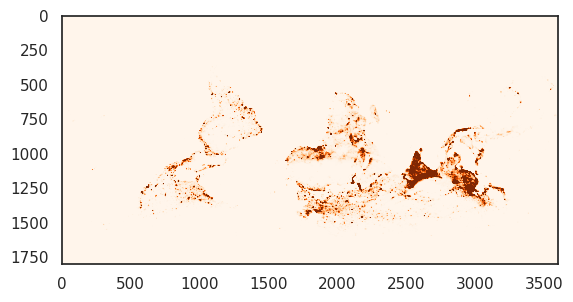

In [34]:


plt.imshow(global_pop_new,cmap='Oranges',vmin=0, vmax=30000)



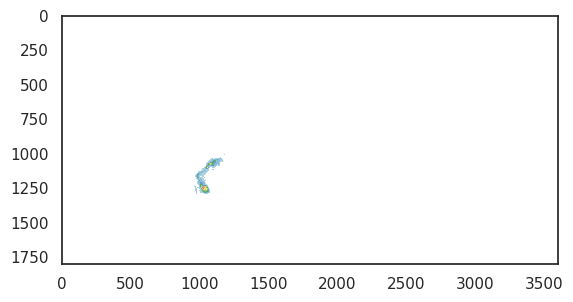

In [35]:
plt.imshow(global_rain,cmap=precip_cmap)


In [36]:
import os

In [37]:
def find_storm_extent(lat,lon,storm):

    lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
    lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
    lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
    lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

    lats = lat[lat_lower_bound:lat_upper_bound+2]
    lons = lon[lon_lower_bound:lon_upper_bound+2]
    grid_x, grid_y = np.meshgrid(lons,lats)
    return grid_x,grid_y


In [38]:
files = os.listdir('/user/home/al18709/work/event_sets/wgan_modular/')
sids = []
for file in files:
    if ('test_mraw_' in file) and ('critic' not in file) and ('extreme' not in file):
        sid = file[10:-3]
        sids.append(sid)

In [39]:
def ets_pred(pred_rain,truth_rain):
    threshold = np.percentile(truth_rain, 90)
    rain_bool = pred_rain > threshold
    # rain_grid_x = grid_X[rain_bool]

    rain_bool_truth = truth_rain > threshold
    # rain_grid_x_truth = grid_X[rain_bool_truth]

    hit = (rain_bool == True) & (rain_bool_truth == True)
    miss = (rain_bool == False) & (rain_bool_truth == True)
    hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))


    false_alarm = (rain_bool == True) & (rain_bool_truth == False)
    correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
    false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))

    n_forecast_points = np.sum(rain_bool == True)
    n_observed_points = np.sum(rain_bool_truth == True)
    total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
    E = (n_forecast_points*n_observed_points) / total_points_possible

    ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)


    return hit_rate,false_alarm_rate,ETS

In [40]:
def get_ets_scores(pred_rain_all,truth_rain_all):
    ntime,_,_,_ = pred_rain_all.shape
    hit_rates = np.zeros((ntime,20))
    false_alarm_rates = np.zeros((ntime,20))
    ETSs = np.zeros((ntime,20))
    for t in range(ntime):
        for e in range(20):
            hit_rate,false_alarm_rate,ETS = ets_pred(pred_rain_all[t,:,:,e],truth_rain_all[t,:,:,0])
            hit_rates[t,e] = hit_rate
            false_alarm_rates[t,e] = false_alarm_rate
            ETSs[t,e] = ETS
    return hit_rates,false_alarm_rates,ETSs

In [41]:
def superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=False):
    grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))

    if (combo == True) or (truth == True):
        grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

    for t in range(ntime):
        s_lons = storm.storm_lons[t,:,:]
        s_lats = storm.storm_lats[t,:,:]
        
        if truth==True:
            storm_rain_truth = storm_truth.precipitation[t,:,:,0]

        Mlon = s_lons[-1,-1]
        mlon = s_lons[0,0]
        Mlat = s_lats[-1,-1]
        mlat = s_lats[0,0]
        Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
        Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

        # Create a selection
        sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]

        if truth == False:
            for i in range(20):
                storm_rain = storm.precipitation[t,:,:,i]
                grid_rain[t,sel[1],sel[0],i] = storm_rain
            
        else:
            grid_rain[t,sel[1],sel[0]] = storm_rain_truth
    
    return grid_rain
        

In [42]:
print(sids)
print(len(sids))

['2004081S12103', '2002195N11172', '2005322S04095', '2017257N16251', '2018117S07098', '2012209N25149', '2017292N13151', '1982136N08140', '2006259N19155', '2000067S15189', '2012066S10101', '2015180N09160', '1987263N10241', '1986262N12266', '2015229N10331', '1990056S11125', '1996179N13266', '2001091S11111', '1994095S08129', '1988251N23268', '1994298N25161', '2007268N10324', '2019021S09128', '1979297N12265', '1980275N34340', '1988290N08145', '2006234N12258', '1994019S17174', '1995220N15256', '1988100S15171', '1991311N10256', '2016194N15255', '1994128N04155', '1992055S13169', '1981070N03173', '2000102S13128', '1989246N16159', '2008198N10265', '1988282N17153', '1994259N12128', '2015218N12231', '1986330N05173', '1994202N11238', '2001265N25296', '1995032S10074', '1999235N27140', '1981012S12110', '2016041S14170', '2011215N24164', '2017061S11063', '1995089S09131', '2012242N24317', '1992212N20135', '1993120S10075', '1996269N09337', '2017257N16258', '1999060S10089', '2007291N19148', '1990264N1432

In [43]:
def ets2(total_storm_rain,total_storm_rain_truth,pop,threshold=50,silent=False):

	# if silent == True:
	# 	sys.stdout = StringIO()

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	# print('Hit rate: ',hit_rate*100)

	# population
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)
	# pop_hit_rate = pop_hit
	datapop = np.copy(pop)
	datapop[~hit] = 0
	# print('pop hits',np.sum(datapop))


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection_1 = (rain_bool == False) & (rain_bool_truth == False)
	rain_bool_truth_crop = crop_blob(rain_bool_truth,rain_bool_truth)
	rain_bool_crop = crop_blob(rain_bool,rain_bool_truth)
	correct_rejection = (rain_bool_crop == False) & (rain_bool_truth_crop == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	# print('false alarm rate',false_alarm_rate*100)

	pop_false_alarm = np.sum(pop[false_alarm])
	# print('pop_false alarm', pop_false_alarm)
	# pop_correct_rejection_1 = np.sum(pop[correct_rejection_1])
	# pop_correct_rejection_1 = pop[correct_rejection_1]
	# print('shape',pop_correct_rejection_1.shape)
	# print('shape',correct_rejection_1.shape)
	# print(pop.shape)
	crop_pop = crop_blob(pop,rain_bool_truth)
	pop_correct_rejection = np.sum(crop_pop[correct_rejection])
	# print(pop_correct_rejection)
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection + 1)
	# print(pop_false_alarm_rate)
	if np.isnan(pop_false_alarm_rate):
		# print(pop_false_alarm_rate)
		# print(pop_false_alarm)
		# print(pop_correct_rejection)
		exit()
	# pop_false_alarm_rate = pop_false_alarm

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	# print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	# print(ETS_pop)
	# if silent == True:
	# 	sys.stdout = sys.__stdout__ 
	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [46]:
modular_hit_rates = np.zeros((len(sids),20))
modular_false_alarm_rates = np.zeros((len(sids),20))
modular_ETS = np.zeros((len(sids),20))
modular_pop_hits = np.zeros((len(sids),20))
modular_pop_misses = np.zeros((len(sids),20))
modular_pop_hit_rates = np.zeros((len(sids),20))
modular_pop_false_alarms = np.zeros((len(sids),20))
modular_pop_correct_rejections = np.zeros((len(sids),20))
modular_pop_false_alarm_rates = np.zeros((len(sids),20))

modular_part2_hit_rates = np.zeros((len(sids),20))
modular_part2_false_alarm_rates = np.zeros((len(sids),20))
modular_part2_ETS = np.zeros((len(sids),20))
modular_part2_pop_hits = np.zeros((len(sids),20))
modular_part2_pop_misses = np.zeros((len(sids),20))
modular_part2_pop_hit_rates = np.zeros((len(sids),20))
modular_part2_pop_false_alarms = np.zeros((len(sids),20))
modular_part2_pop_correct_rejections = np.zeros((len(sids),20))
modular_part2_pop_false_alarm_rates = np.zeros((len(sids),20))

scalar_hit_rates = np.zeros((len(sids),20))
scalar_false_alarm_rates = np.zeros((len(sids),20))
scalar_ETS = np.zeros((len(sids),20))
scalar_pop_hits = np.zeros((len(sids),20))
scalar_pop_misses = np.zeros((len(sids),20))
scalar_pop_hit_rates = np.zeros((len(sids),20))
scalar_pop_false_alarms = np.zeros((len(sids),20))
scalar_pop_correct_rejections = np.zeros((len(sids),20))
scalar_pop_false_alarm_rates = np.zeros((len(sids),20))

for j,sid in enumerate(np.sort(sids)):
    print('SID',sid)
    if sid in ['2002298N17169','2002298N17169','2016041S14170','1988100S15171','1994019S17174','2010040S11185','2003068S14172','1988242N12215','1979002S04179','1979083S15184','1980069S12161',' 1982024S18166','1982024S18166','1993053S12161','2017127S18184']:
        continue
    
    storm = xr.open_dataset('/user/home/al18709/work/event_sets/wgan_modular/' + f'test_mraw_{sid}.nc')
    storm_2 = xr.open_dataset('/user/home/al18709/work/event_sets/wgan_modular/' + f'test_1and2_{sid}.nc')
    storm_3 = xr.open_dataset('/user/home/al18709/work/event_sets/wgan_scalar/' + f'test_{sid}.nc')
    storm_truth = xr.open_dataset('/user/home/al18709/work/event_sets/truth/' + f'test_{sid}.nc')
    
    # ETS_scores = get_ets_scores(storm_2.precipitation.values,storm_truth.precipitation.values)
    # print(ETS_scores)

    lats = storm.storm_lats[0,:,:]
    lons = storm.storm_lons[0,:,:]
    if (np.sum(lons > 175) > 0) or (np.sum(lons < - 175)>0):
        continue
    # print(lons.values)
    ntime,_,_,_ = storm.precipitation.shape
    rain = storm.precipitation[0,:,:,0]
    rain2 = storm_2.precipitation[0,:,:,0]
    rain_truth = storm_truth.precipitation[0,:,:,0]

    grid_x,grid_y = find_storm_extent(lat,lon,storm)
    grid_rain_1 = superimpose_rain_onto_bigger_grid(storm,ntime,grid_x,grid_y,combo=False,truth=False)
    grid_rain_2 = superimpose_rain_onto_bigger_grid(storm_2,ntime,grid_x,grid_y,combo=False,truth=False)
    grid_rain_3 = superimpose_rain_onto_bigger_grid(storm_3,ntime,grid_x,grid_y,combo=False,truth=False)
    grid_rain_truth = superimpose_rain_onto_bigger_grid(storm_truth,ntime,grid_x,grid_y,combo=False,truth=True)

    accumulated_rain1 = np.sum(grid_rain_1[:,:,:,:],axis=0)
    accumulated_rain2 = np.sum(grid_rain_2[:,:,:,:],axis=0)
    accumulated_rain3 = np.sum(grid_rain_3[:,:,:,:],axis=0)
    accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)
        
    
    global_rain1 = np.zeros((pop.population.shape[0],pop.population.shape[1],20))
    global_rain2 = np.zeros((pop.population.shape[0],pop.population.shape[1],20))
    global_rain3 = np.zeros((pop.population.shape[0],pop.population.shape[1],20))
    global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

    # superimpose rain onto bigger grid
    storm_lons = grid_x
    storm_lats = grid_y
    # storm_rain_1 = np.sum(accumulated_rain,axis=0)
    # storm_rain_2 = np.sum(accumulated_rain2,axis=0)
    # storm_rain_3 = np.sum(accumulated_rain3,axis=0)
    # storm_rain_truth = np.sum(accumulated_rain_truth,axis=0)
    

    Mlon = storm_lons[-1,-1]
    mlon = storm_lons[0,0]
    Mlat = storm_lats[-1,-1]
    mlat = storm_lats[0,0]
    grid_X,grid_Y = np.meshgrid(lon,lat)
    Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
    Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

    # Create a selection
    sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
    global_rain1[sel[1],sel[0],:] = accumulated_rain1
    global_rain2[sel[1],sel[0],:] = accumulated_rain2
    global_rain3[sel[1],sel[0],:] = accumulated_rain3
    global_rain_truth[sel[1],sel[0]] = accumulated_rain_truth

    # hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20)),np.zeros((20))
    threshold = 50
    # threshold = np.percentile(global_rain_truth[global_rain_truth > 0],75)
    threshold = np.percentile(global_rain_truth[global_rain_truth > 0],95)
    print('threshold = ',threshold)
    # for i in range(20):
    #     modular_hit_rates[j,i],modular_false_alarm_rates[j,i],modular_ETS[j,i],modular_pop_hits[j,i],modular_pop_misses[j,i],modular_pop_hit_rates[j,i],modular_pop_false_alarms[j,i],modular_pop_correct_rejections[j,i],modular_pop_false_alarm_rates[j,i] = ets2(global_rain2[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    #     modular_part2_hit_rates[j,i],modular_part2_false_alarm_rates[j,i],modular_part2_ETS[j,i],modular_part2_pop_hits[j,i],modular_part2_pop_misses[j,i],modular_part2_pop_hit_rates[j,i],modular_part2_pop_false_alarms[j,i],modular_part2_pop_correct_rejections[j,i],modular_part2_pop_false_alarm_rates[j,i] = ets2(global_rain1[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    #     scalar_hit_rates[j,i],scalar_false_alarm_rates[j,i],scalar_ETS[j,i],scalar_pop_hits[j,i],scalar_pop_misses[j,i],scalar_pop_hit_rates[j,i],scalar_pop_false_alarms[j,i],scalar_pop_correct_rejections[j,i],scalar_pop_false_alarm_rates[j,i] = ets2(global_rain3[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)
    
    for i in range(1):
        modular_hit_rates[j,i],modular_false_alarm_rates[j,i],modular_ETS[j,i],modular_pop_hits[j,i],modular_pop_misses[j,i],modular_pop_hit_rates[j,i],modular_pop_false_alarms[j,i],modular_pop_correct_rejections[j,i],modular_pop_false_alarm_rates[j,i] = ets2(global_rain2[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)
        modular_part2_hit_rates[j,i],modular_part2_false_alarm_rates[j,i],modular_part2_ETS[j,i],modular_part2_pop_hits[j,i],modular_part2_pop_misses[j,i],modular_part2_pop_hit_rates[j,i],modular_part2_pop_false_alarms[j,i],modular_part2_pop_correct_rejections[j,i],modular_part2_pop_false_alarm_rates[j,i] = ets2(global_rain1[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)
        scalar_hit_rates[j,i],scalar_false_alarm_rates[j,i],scalar_ETS[j,i],scalar_pop_hits[j,i],scalar_pop_misses[j,i],scalar_pop_hit_rates[j,i],scalar_pop_false_alarms[j,i],scalar_pop_correct_rejections[j,i],scalar_pop_false_alarm_rates[j,i] = ets2(global_rain3[:,:,i],global_rain_truth,global_pop_new,threshold=threshold,silent=True)




SID 1979043S11161


threshold =  101.9500041206053
SID 1979297N12265
threshold =  117.58750155301288


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1979329S07086
threshold =  92.75000401737655


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1979343S08093
threshold =  55.249999877309634


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980018S10130
threshold =  98.884378411916


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980227N13325
threshold =  29.312501357801562


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980245N16322
threshold =  67.1875032792652


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980275N34340
threshold =  25.625000694260773


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1980277N09157
threshold =  163.56250089151496
SID 1981012S12110
threshold =  81.74999951427256


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1981055S19120
threshold =  101.36562641945414


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1981070N03173
threshold =  132.06562557930286
SID 1982095S11138
threshold =  153.8124995130683
SID 1982136N08140
threshold =  135.0156244758216
SID 1982210N11245
threshold =  59.93750175834016


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982213N13145
threshold =  252.9281233439325
SID 1982221N10236
threshold =  112.81250126371839


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1982229N09154
threshold =  199.62499766464532
SID 1982262N12270
threshold =  131.89999839804577
SID 1982286N09170
threshold =  170.18749745539648
SID 1982324N10193
threshold =  159.9499977050121
SID 1982325N08176
threshold =  109.31249809820763
SID 1983066S11213
threshold =  284.2437488642608
SID 1983082S11180
SID 1983274N12251
threshold =  60.9375003281127


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1983353S08070
threshold =  144.37500115053038
SID 1984022S08086
threshold =  148.6874977153767


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984035S09101
threshold =  274.44688249223765


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984094S10080
threshold =  167.76874907352527
SID 1984150N12266
threshold =  102.12500055318337
SID 1984169N14257
threshold =  115.27812802445428


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984180N10258
threshold =  32.62500095207023


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984270N13262
threshold =  35.50000116704645
SID 1984294N04163
threshold =  159.0999983443423


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1984348N35300
threshold =  25.750000206587654


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1985162N05154
threshold =  223.12500665433197
SID 1985259N12262
threshold =  99.13437501565733


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1985280N15254
threshold =  51.60624905409333
SID 1985294N10122
threshold =  192.87499765141814
SID 1985329S09104
threshold =  166.56249156740387


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986027S13145
threshold =  175.74999839816934
SID 1986061S13124
threshold =  124.50000104963677


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986111S08156
threshold =  74.7718755210903
SID 1986135S07160
threshold =  339.80309086603563
SID 1986233N10263
threshold =  68.06250470653674


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986262N12266
threshold =  57.499999335816945
SID 1986283N10179
threshold =  98.12499980967053


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986289N10267
threshold =  125.75000058253302


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986330N05173
threshold =  119.49999565967202


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1986356S07183
SID 1987007N06162
threshold =  114.17187283781408


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987062S13072
threshold =  468.25000355373896


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987176N10150
threshold =  72.49999970618852
SID 1987200N04191
SID 1987202N09144
threshold =  136.88750407825012
SID 1987213N11268
threshold =  127.1250036414586


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987219N08134
threshold =  148.31250129115625
SID 1987263N10241
threshold =  87.81249962109322


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987279N12256
threshold =  139.16249883862133


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1987282N15277
threshold =  91.18750408766076
SID 1987343N05154
threshold =  72.12500055056627
SID 1988028S07100
threshold =  95.04999662668298


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988100S15171
SID 1988211N12239
threshold =  119.24999964362476


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988226N22173
threshold =  138.43750339947582


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988249N18163
threshold =  217.97187412273644


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988251N23268
threshold =  69.06250177588477
SID 1988274N12142
threshold =  183.28437570048703
SID 1988282N17153
threshold =  92.05312486519897


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1988290N08145
threshold =  112.78749778244662
SID 1989080S16066
threshold =  346.2000109177793


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1989211N24153
threshold =  111.37499793657385
SID 1989246N16159
threshold =  256.87500592371674
SID 1989271N14168
threshold =  172.2250034826745
SID 1989272N18120
threshold =  127.18750086296549
SID 1989309S07100
threshold =  139.4812510594595


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1989354N05155
threshold =  193.609374422273


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990032S11059
threshold =  117.75000185905807


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990056S11125
threshold =  112.74999665248423


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990058S16075
threshold =  270.31250431704177


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990166N06141
threshold =  218.3125064008664
SID 1990187N13258
threshold =  97.68750017766118
SID 1990206N34285
threshold =  110.62499412733841
SID 1990229N11261
threshold =  105.93750203757702


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990234N14248
threshold =  79.87499818142999


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990251N12238
threshold =  139.46875435102763


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990264N14328
threshold =  61.937500383281915


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990267N13252
threshold =  88.65312479084366


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990277N16301
threshold =  173.60312301931884


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1990279N36316
threshold =  23.625000423834347
SID 1990309N08167
threshold =  185.10000046977913
SID 1990310N07152
threshold =  175.43749469368623
SID 1990319N07197
threshold =  276.37500675838885


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991083S11100
threshold =  188.43749613338255


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991174N13259
threshold =  74.49999993842503
SID 1991311N10256
threshold =  71.87500042086677


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1991329N04181
threshold =  66.24999697971273
SID 1992055S13169
threshold =  345.12499666485326
SID 1992197N11266
threshold =  91.18749946269787
SID 1992212N20135
threshold =  146.98749905035936


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1992249N12229
threshold =  146.4999990877897
SID 1992281N11263
threshold =  112.62812484493105
SID 1992318N11160
threshold =  111.00000170921115
SID 1992338S04173
SID 1993043S11193
threshold =  65.81250015715393
SID 1993120S10075
threshold =  222.36562980601144


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993162N10245
threshold =  188.00000023201528


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993221N13256
threshold =  123.18750388896714


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1993227N15258
threshold =  84.4999999214979
SID 1994010S17124
threshold =  49.56250211489625


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994019S17174
SID 1994036S09075
threshold =  128.18749790151634
SID 1994067S14109
threshold =  52.500000575491654


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994095S08129
threshold =  74.3781272122255


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994128N04155
threshold =  119.06250252071051


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994202N11238
threshold =  81.11874699420976


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994223N15253
threshold =  31.99999963156362
SID 1994237N24167
threshold =  132.18750470958304


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994244N07151
threshold =  143.18437461585933


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994259N12128
threshold =  222.80937351454168
SID 1994265N13251
threshold =  142.50624501128925


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994282N17247
threshold =  136.6750010303397
SID 1994291N12170
threshold =  236.93750257463302


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994298N25161
threshold =  117.37499964127906


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1994325S06076
threshold =  276.8750032079298


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995017S10078
threshold =  132.81249859748118


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995032S10074
threshold =  80.12500075373002


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995088S10078
threshold =  378.91562698990606


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1995089S09131
threshold =  137.43124673805457
SID 1995220N15256
threshold =  119.12500052001326
SID 1995292N08150
threshold =  94.2500000673113
SID 1995300N25301
threshold =  56.18749866209408


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996007S10100
threshold =  83.6875042188259


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996026S14143
threshold =  120.43750151977181
SID 1996093S16074
threshold =  264.4374978148391


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996128N07138
threshold =  189.40312948569505
SID 1996172N13261
threshold =  148.74687322991497
SID 1996179N13266
threshold =  151.62500398554337
SID 1996187N10326
threshold =  77.90937610429532
SID 1996210N05156
threshold =  225.4999975050766
SID 1996232N21170
threshold =  54.303125851657946


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996246N08148
threshold =  76.68750135340454
SID 1996269N09337
threshold =  71.56250067846474


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996282N11162
threshold =  101.31250188977481
SID 1996357S10136
threshold =  172.81250327344395


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1996365S15137
threshold =  126.62500015748103
SID 1997018S11059
threshold =  243.06250029008203
SID 1997061S08171
SID 1997210N15120
threshold =  151.77187837831647
SID 1997212N11265
threshold =  132.68750550526534


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1997217N06168
threshold =  197.62500590121388
SID 1997240N12193
SID 1997284N04179
threshold =  128.9375048068091


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1997311N10151
threshold =  80.56249973715258
SID 1997326S09203
threshold =  178.56249787745878


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998001S09195
threshold =  138.759379980658


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998036S13135
threshold =  44.56250054453906


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998087S15172
SID 1998173N08266
threshold =  99.09999600686601


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1998336S13120
threshold =  58.490623800889054
SID 1999015S20036
threshold =  72.25000313090085


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999060S10089
threshold =  131.68750201891476
SID 1999074S13132
threshold =  154.10937859248878


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999084S12119
threshold =  115.37500260404184


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999189N12263
threshold =  65.29687321617666


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999217N11265
SID 1999235N27140
threshold =  26.812499163161714


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 1999286N16278
threshold =  138.12813557322252
SID 2000025S15056
threshold =  141.62500158783234


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000050S13078
threshold =  82.1875032150653


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000067S15189
SID 2000083S17102
threshold =  105.06250234765903
SID 2000102S13128
threshold =  153.77187986881208


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000217N12260
threshold =  82.78750295507794


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000222N14143
threshold =  129.37499978436912


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000223N18257
threshold =  43.00000079180758


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2000249N15258
threshold =  153.63125325684314


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001064S10052
threshold =  151.1250042275252


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001091S11111
threshold =  113.87499809853557


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001106S08137
threshold =  63.13437754130622
SID 2001170N11138
threshold =  107.62500085790042
SID 2001204N19127
threshold =  80.6062461319026
SID 2001259N20138
threshold =  41.62499918971623


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001264N21126
threshold =  256.7499972610236
SID 2001265N25296
threshold =  49.062498740664005


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001291N05158
threshold =  204.8124923187432


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001304N12237
threshold =  49.70312445451508


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2001308N34310
threshold =  15.97187488109707


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2002030S13093
threshold =  336.8750039662623


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2002122S07063
threshold =  193.9718813258925
SID 2002195N11172
SID 2002200N21150
threshold =  75.92187420286042


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2002240N16155
threshold =  151.60937357080647
SID 2002242N14257
threshold =  99.31249497578737
SID 2002264N28308
threshold =  77.60312416057214
SID 2002265N10315
threshold =  61.937498114564725
SID 2002268N15163
threshold =  75.62499611424121
SID 2002298N17169
SID 2002356S07070
threshold =  112.24999723288038


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2003007S10072
threshold =  145.62500337632264


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2003034S12117
threshold =  126.19375629209148


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2003138N04148
threshold =  162.71250044712977


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)


SID 2003188N11307
threshold =  59.43750119753291
SID 2003196N05150
threshold =  193.43749642667095
SID 2003226N07156
threshold =  133.49999755801673
SID 2003249N14329
threshold =  127.68750228530808
SID 2003257N15252
threshold =  59.48125037411077


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2003294N10260
threshold =  88.2406245659577


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004025S16044
threshold =  281.75000195166626
SID 2004056S18125
threshold =  165.81250016806823
SID 2004081S12103
threshold =  104.08437815278114


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004206N20151
threshold =  132.6124988980986
SID 2004216N16166
threshold =  104.1875003784605


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004236N17250
threshold =  28.249999190013643
SID 2004252N15250
threshold =  69.68749567113716


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004260N11331
threshold =  100.26562837854485


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2004319N10134
threshold =  143.8250040530326
SID 2004325S06078
threshold =  282.81250198565914


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005185N18273
threshold =  48.18750235228012
SID 2005229N21156
threshold =  77.37499535348391


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005237N14148
threshold =  135.81250053794096
SID 2005282N22138
threshold =  147.38125002900136


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2005300N10279
threshold =  112.37500224815248
SID 2005322S04095
threshold =  149.43437012068304


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006025S18147
SID 2006114N08090
threshold =  170.6875020801222
SID 2006216N07151
threshold =  66.06249973966595
SID 2006234N12258
threshold =  73.4093765379034
SID 2006240N12265
threshold =  116.74999765613715
SID 2006259N19155
threshold =  132.31249513985432


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2006268N12129
threshold =  124.31250431292673
SID 2007021S12183
threshold =  50.87499854834422
SID 2007052S10093
threshold =  232.18750610948953


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007062S14119
threshold =  107.64062875812988


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007135N08147
threshold =  95.31249659007524


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007268N10324
threshold =  96.5781260853295


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007291N19148
threshold =  85.18750349865603


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007306N18133
threshold =  105.76874770340278
SID 2007322S06075
threshold =  97.18749914559675


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2007337S12186
SID 2008083S12102
threshold =  157.62499878896526


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2008147N10141
threshold =  166.22812622157662


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2008169N08135
threshold =  160.92500074138337
SID 2008179N12252
threshold =  133.4375048222717


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2008198N10265
threshold =  96.6625014932698


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2008206N22133
threshold =  183.00937964822975
SID 2008343N16168
threshold =  130.37499926218476


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2009017S20043
threshold =  152.42499508716404
SID 2009032S15071
threshold =  169.7499992403936


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2009190N09254
threshold =  118.68750013810347


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2009288N07267
threshold =  155.75000624385538
SID 2009342S09140
threshold =  205.1187507829635
SID 2010091S09093
threshold =  285.5249943496604


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2010176N16278
threshold =  115.18749893104018
SID 2010236N12341
threshold =  73.87500157697903
SID 2010240N15142
threshold =  67.99999766979037
SID 2010263N15149
threshold =  146.56249926830878


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2010302N09306
threshold =  102.25000043250435
SID 2010302N26299
threshold =  16.249999401193804


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2011020S13182
SID 2011212N10264
threshold =  103.56250256753647


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2011215N24164
threshold =  138.33749594917677


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2011323N09264
threshold =  59.56250319563614


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012039S14075
threshold =  138.6875027219582


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012066S10101
threshold =  138.43749403365004


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012166N09269
threshold =  82.03437506037396
SID 2012189N10262
threshold =  85.5624964702953


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012193N12259
threshold =  100.12500462598811


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012201N15129
threshold =  129.5062517943937
SID 2012209N25149
threshold =  52.81249835811261
SID 2012219N12254
threshold =  67.06250195080592


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012225N16133
threshold =  148.8343743646942
SID 2012232N13141
threshold =  257.6875043000948
SID 2012242N24317
threshold =  27.918748684248293


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2012254N09135
threshold =  149.00000208574636
SID 2012287N15297
threshold =  101.18749989327544
SID 2012337S06089
threshold =  152.81250444769498


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2013093S08074
threshold =  292.68749391804107


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2013186N13262
threshold =  87.25000079264487
SID 2013274N18152
threshold =  73.12499829625673
SID 2013339N09084
threshold =  256.79374513368225


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2014204N10239
SID 2014209N12152
threshold =  213.93749802336103
SID 2014229N16246
threshold =  133.6875065802448


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2014303N11261
threshold =  125.68749987957843


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015024S15078
threshold =  111.46250239358093


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015047S15152
threshold =  83.00000385498697
SID 2015127N04158
threshold =  183.00000038065505
SID 2015180N09160
threshold =  178.25000173292648
SID 2015192N11263
threshold =  108.39375138167034


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015218N12231
threshold =  66.4375011545828


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015229N10331
threshold =  58.937501040609


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015238N10255
threshold =  151.18750129880854


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015248N10256
threshold =  99.76562559932835


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2015285N14151
threshold =  229.12187040430211
SID 2015288N10243
threshold =  203.07812482605584


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016041S14170
SID 2016194N15255
threshold =  48.81249786016723


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016237N14253
threshold =  51.25000257070769


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016266N11144
threshold =  146.0625017852109
SID 2016269N15165
threshold =  84.24999990181695
SID 2016288N07145
threshold =  138.7499969722114
SID 2016305N10147
threshold =  98.6343753691676


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2016355N07146
threshold =  90.81250294716902
SID 2017033S14056
threshold =  121.87499816922913
SID 2017061S11063
threshold =  230.56250603087486


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2017247N09327
threshold =  142.31250227991652


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2017257N16251
threshold =  108.8749979154854


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2017257N16258
threshold =  64.70625076912899
SID 2017292N13151
threshold =  89.68124555517923
SID 2017333N06082
threshold =  174.37499131027707
SID 2018060S13057
threshold =  244.8749952198381


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018111S07055
threshold =  98.31249671827881
SID 2018117S07098
threshold =  92.72812555306616


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018182N11256
threshold =  88.18750219924402


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018218N14255
threshold =  96.68750118725153


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018226N11245
threshold =  103.7500054111893
SID 2018238N13239
threshold =  89.87500457208829


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2018239N11161
threshold =  91.87500054639186
SID 2018268N14253
threshold =  102.93749504506758


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019021S09128
threshold =  131.5624969176856


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019074S08151
threshold =  198.30624547788142
SID 2019078S13066
threshold =  267.11250745843944


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019112S10053
threshold =  110.2500014389908
SID 2019213N17155
threshold =  53.00000122662694
SID 2019236N10314
threshold =  116.18750584441042
SID 2019244N13253
threshold =  70.00312616066063


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019260N13317
threshold =  73.8124993735898


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019260N20129
threshold =  145.3124939723782
SID 2019308N13114
threshold =  214.2062524679005


/tmp/ipykernel_264531/3305033517.py:20: RuntimeWarning: invalid value encountered in scalar divide
  pop_hit_rate = pop_hit / (pop_hit + pop_miss)
/tmp/ipykernel_264531/3305033517.py:73: RuntimeWarning: invalid value encountered in scalar divide
  ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)


SID 2019314N14136
threshold =  143.8156234250874
SID 2020230N11264
threshold =  70.3749958394541
SID 2020256N25281
threshold =  213.08124882868304
SID 2020306N15288
threshold =  130.1875012875513


/tmp/ipykernel_264531/2770750271.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(labels)


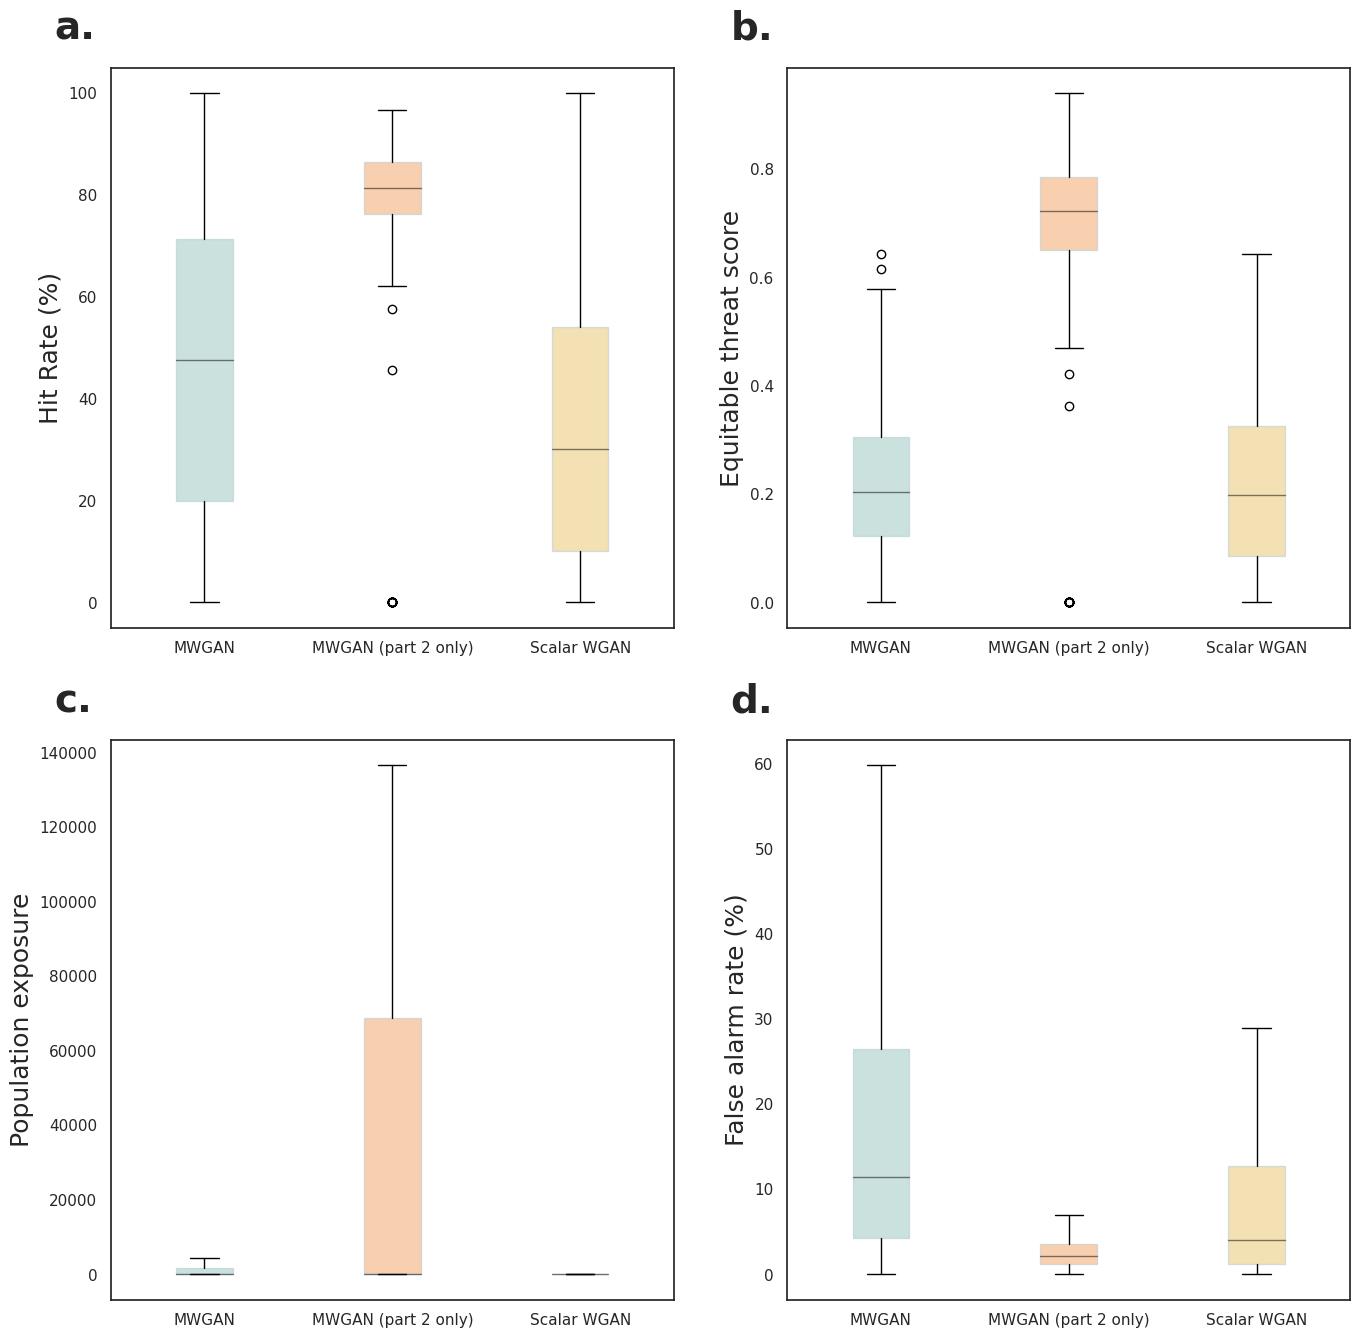

In [47]:
# Sample data
categories = ['Ensemble member {}'.format(i) for i in range(1, 24)]
# hit_rates = np.random.uniform(0, 100, size=(20, 22))  # Example hit rates, replace with your actual data

hit_rates = np.concatenate((np.expand_dims(modular_hit_rates[:,0],axis=1),np.expand_dims(modular_part2_hit_rates[:,0],axis=1),np.expand_dims(scalar_hit_rates[:,0],axis=1)),axis=1)*100

ETSs = np.concatenate((np.expand_dims(modular_ETS[:,0],axis=1),np.expand_dims(modular_part2_ETS[:,0],axis=1),np.expand_dims(scalar_ETS[:,0],axis=1)),axis=1)

pop_hits = np.concatenate((np.expand_dims(modular_pop_hits[:,0],axis=1),np.expand_dims(modular_part2_pop_hits[:,0],axis=1),np.expand_dims(scalar_pop_hits[:,0],axis=1)),axis=1)

false_alarm_rate = np.concatenate((np.expand_dims(modular_false_alarm_rates[:,0],axis=1),np.expand_dims(modular_part2_false_alarm_rates[:,0],axis=1),np.expand_dims(scalar_false_alarm_rates[:,0],axis=1)),axis=1)*100

palette = ['blue'] + ['red'] + ['yellow']

# Create box plots using Seaborn
# sns.boxplot(data=data, palette=palette)

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
bplt = axs[0,0].boxplot(hit_rates, patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))
# bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[0,0].set_ylabel('Hit Rate (%)',fontsize=18)
axs[1,0].set_ylabel('Population exposure',fontsize=18)
axs[1,1].set_ylabel('False alarm rate (%)',fontsize=18)
# axs[0,0].set_title('Hit Rates')

# Set tick labels for the last 4 ticks as words vertically
labels = ['MWGAN','MWGAN (part 2 only)','Scalar WGAN']
axs[0,0].set_xticklabels(labels)

bplt = axs[0,1].boxplot(ETSs, vert=True,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))
axs[0,1].set_ylabel('Equitable threat score',fontsize=18)
# axs[0,1].set_title('ETS')
# bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[1,0].set_xticklabels(labels)

bplt = axs[1,0].boxplot(pop_hits, vert=True,showfliers=False,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))

# axs[1,0].set_title('pop hits')
# bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')
axs[0,1].set_xticklabels(labels)

bplt = axs[1,1].boxplot(false_alarm_rate, vert=True,showfliers=False,patch_artist=True, medianprops=dict(color='black', alpha=0.5), boxprops=dict(color='#aec7d1', alpha=0.5))

# axs[1,1].set_title('false alarm rate')
# bplt['boxes'][-4].set_facecolor('#97c4bf')
bplt['boxes'][-3].set_facecolor('#97c4bf')
bplt['boxes'][-2].set_facecolor('#f4a261')
bplt['boxes'][-1].set_facecolor('#e9c46a')

axs[1,1].set_xticklabels(labels)


axs[0,0].text(-0.1, 1.05, 'a.', transform=axs[0,0].transAxes, size=28, weight='bold')
axs[0,1].text(-0.1, 1.05, 'b.', transform=axs[0,1].transAxes, size=28, weight='bold')
axs[1,0].text(-0.1, 1.05, 'c.', transform=axs[1,0].transAxes, size=28, weight='bold')
axs[1,1].text(-0.1, 1.05, 'd.', transform=axs[1,1].transAxes, size=28, weight='bold')

# Rotate x-axis labels vertically
# plt.xticks(rotation=90)
# plt.xticks(range(1, 23), categories)

plt.savefig('test_hit_rates_95.png',bbox_inches='tight')